# Setup

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/My Drive/[2024-2025] AN2DL HW2

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1z5t8kqLSNnsGWmeDMitEc48VDF9xBUOx/[2024-2025] AN2DL HW2


In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import inspect

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## Split

In [ ]:
# Load the cleaned dataset
data = np.load("mars_cleaned_dataset.npz")
X = data["X_train"]
y = data["y_train"]
X_final_test = data["X_test"]

# Split
test_size = 0.15
adjusted_val_size = 0.176
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=test_size, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=adjusted_val_size, random_state=seed
)

# Turning np dataset in tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
final_test_dataset = tf.data.Dataset.from_tensor_slices(X_final_test)

# Print out the number of batches in each dataset (after batching)
print(f"\nNumber of batches:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")
print(f"Final Test: {len(final_test_dataset)}")


Number of batches:
Train: 1754
Validation: 375
Test: 376
Final Test: 10022


## Class Weights

In [ ]:
# Define class labels for better readability
class_labels = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]

# Ensure input is a 1D array of integers
y_vector = np.ravel(y_train).astype(int)

# Calculate class counts
class_counts = np.bincount(y_vector, minlength=len(class_labels))

# Calculate frequency percentages
class_frequencies = class_counts / np.sum(class_counts) * 100

# Display class counts and percentages
print("Class Distribution:\n")
for i, (count, freq) in enumerate(zip(class_counts, class_frequencies)):
    print(f"Class {i} ({class_labels[i]}):")
    print(f"    Pixels: {count}")
    print(f"    Frequency: {freq:.2f}%")

# Calculate raw weights as the inverse of the frequencies
raw_weights = {cls: 1.0 / freq for cls, freq in zip(range(len(class_frequencies)), class_frequencies)}

# Normalize the weights so that their sum equals the number of classes
sum_of_raw_weights = sum(raw_weights.values())
num_classes = len(class_labels)

normalized_weights = {cls: (weight / sum_of_raw_weights) * num_classes for cls, weight in raw_weights.items()}

# Display results
print("Class Frequencies:", class_frequencies)
print("Raw Weights:", raw_weights)
print("Normalized Weights:", normalized_weights)

Class Distribution:

Class 0 (Background):
    Pixels: 3512496
    Frequency: 24.45%
Class 1 (Soil):
    Pixels: 4863886
    Frequency: 33.85%
Class 2 (Bedrock):
    Pixels: 3498998
    Frequency: 24.35%
Class 3 (Sand):
    Pixels: 2473313
    Frequency: 17.21%
Class 4 (Big Rock):
    Pixels: 20075
    Frequency: 0.14%
Class Frequencies: [24.44535259 33.85040388 24.35141273 17.21311806  0.13971274]
Raw Weights: {0: 0.04090757114029454, 1: 0.029541745016227763, 2: 0.0410653792885849, 3: 0.05809522692841545, 4: 7.157543212951432}
Normalized Weights: {0: 0.027915051306267202, 1: 0.02015908803229728, 2: 0.02802273852487435, 3: 0.0396437919717635, 4: 4.884259330164797}


# Data Augmentation

In [ ]:
def visualize_transformation(dataset, transformation_fn, **kwargs):
    """
    Visualizes an image and its label before and after a transformation.

    Args:
        dataset: tf.data.Dataset containing image and label pairs.
        transformation_fn: Transformation function to apply.
        **kwargs: Additional arguments for the transformation function.
    """
    # Get one example from the dataset
    for image, label in dataset.take(1):
        break

    # Apply the transformation
    transformed_image, transformed_label = transformation_fn(image, label, **kwargs)

    # Get the transformation function name dynamically
    transformation_name = inspect.getsource(transformation_fn).split('def ')[1].split('(')[0].strip()

    # Plot the results
    plt.figure(figsize=(12, 6))

    # Original Image and Label
    plt.subplot(2, 2, 1)
    plt.title("Original Image")
    plt.imshow(image.numpy(), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 2, 2)
    plt.title("Original Label")
    plt.imshow(label.numpy(), cmap="jet")  # Colorized label
    plt.axis("off")

    # Transformed Image and Label
    plt.subplot(2, 2, 3)
    plt.title(f"Transformed Image ({transformation_name})")
    plt.imshow(transformed_image.numpy(), cmap="gray")
    plt.axis("off")

    plt.subplot(2, 2, 4)
    plt.title(f"Transformed Label ({transformation_name})")
    plt.imshow(transformed_label.numpy(), cmap="jet")  # Colorized label
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistently applies random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure image and label have a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.flip_left_right(image)
    label = tf.image.flip_left_right(label)

    # Remove the channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label

@tf.function
def random_vertical_flip(image, label, seed=None):
    """Consistently applies random vertical flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure image and label have a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    image = tf.image.flip_up_down(image)
    label = tf.image.flip_up_down(label)

    # Remove the channel dimension
    image = tf.squeeze(image, axis=-1)
    label = tf.squeeze(label, axis=-1)

    return image, label

@tf.function
def random_rescale(image, label, min_scale=1, max_scale=1.4, seed=None):
    if seed is not None:
        tf.random.set_seed(seed)

    # Add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)

    # Get the original image size
    original_height, original_width = tf.shape(image)[0], tf.shape(image)[1]

    # Generate a random scaling factor
    scale = tf.random.uniform([], minval=min_scale, maxval=max_scale, seed=seed)

    # Compute the new dimensions
    new_height = tf.cast(scale * tf.cast(original_height, tf.float32), tf.int32)
    new_width = tf.cast(scale * tf.cast(original_width, tf.float32), tf.int32)

    # Resize the image and label
    image_resized = tf.image.resize(image, [new_height, new_width], method='bilinear')
    label_resized = tf.image.resize(label, [new_height, new_width], method='nearest')  # Nearest neighbor for labels

    # Crop back to the original size (center crop)
    image_rescaled = tf.image.resize_with_crop_or_pad(image_resized, original_height, original_width)
    label_rescaled = tf.image.resize_with_crop_or_pad(label_resized, original_height, original_width)
    #rebring to 2d image
    # Add a channel dimension
    image_rescaled = tf.squeeze(image_rescaled, axis=-1)
    label_rescaled = tf.squeeze(label_rescaled, axis=-1)

    return image_rescaled, label_rescaled

def random_rotation(image, label, max_angle=30, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Generate a random angle in degrees
    angle = tf.random.uniform([], minval=-max_angle, maxval=max_angle, seed=seed)
    angle_rad = angle * (3.14159265359 / 180)  # Convert degrees to radians

    # Add a channel dimension if the image is 2D
    if len(image.shape) == 2:
        image = tf.expand_dims(image, axis=-1)
        label = tf.expand_dims(label, axis=-1)

    # Rotate image and label
    image_rotated = tf.image.rot90(image, k=tf.cast(angle_rad // 90, tf.int32))
    label_rotated = tf.image.rot90(label, k=tf.cast(angle_rad // 90, tf.int32))

    # Remove the channel dimension if it was added
    if len(image.shape) == 3 and image.shape[-1] == 1:
        image_rotated = tf.squeeze(image_rotated, axis=-1)
        label_rotated = tf.squeeze(label_rotated, axis=-1)

    return image_rotated, label_rotated

@tf.function
def random_gaussian_noise(image, label, mean=0.0, stddev=1.0, seed=None):
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure image is one-channel and in float32 for noise addition
    image = tf.cast(image, tf.float32)

    # Generate Gaussian noise with the same shape as the image
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, seed=seed)

    # Add noise to the image
    noisy_image = image + noise

    # Clip values to maintain valid range [0, 255]
    noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)

    # Cast the noisy image to float64 (64-bit)
    noisy_image = tf.cast(noisy_image, tf.float64)

    return noisy_image, label

@tf.function
def random_brightness(image, label, max_delta=30, seed=None):
    """Adjusts the brightness of the image by a random factor."""
    if seed is not None:
        tf.random.set_seed(seed)

    adjusted_image = tf.image.random_brightness(image, max_delta=max_delta)
    adjusted_image = tf.clip_by_value(adjusted_image, 0.0, 255.0)

    return adjusted_image, label

@tf.function
def random_contrast(image, label, lower=0.5, upper=1.5, seed=None):
    """Adjusts the contrast of the image by a random factor."""
    if seed is not None:
        tf.random.set_seed(seed)

    # Add a channel dimension
    image = tf.expand_dims(image, axis=-1)
    contrast_factor = tf.random.uniform([], lower, upper)
    adjusted_image = tf.image.adjust_contrast(image, contrast_factor)
    adjusted_image = tf.clip_by_value(adjusted_image, 0.0, 255.0)
    # Remove the channel dimension
    adjusted_image = tf.squeeze(adjusted_image, axis=-1)

    return adjusted_image, label

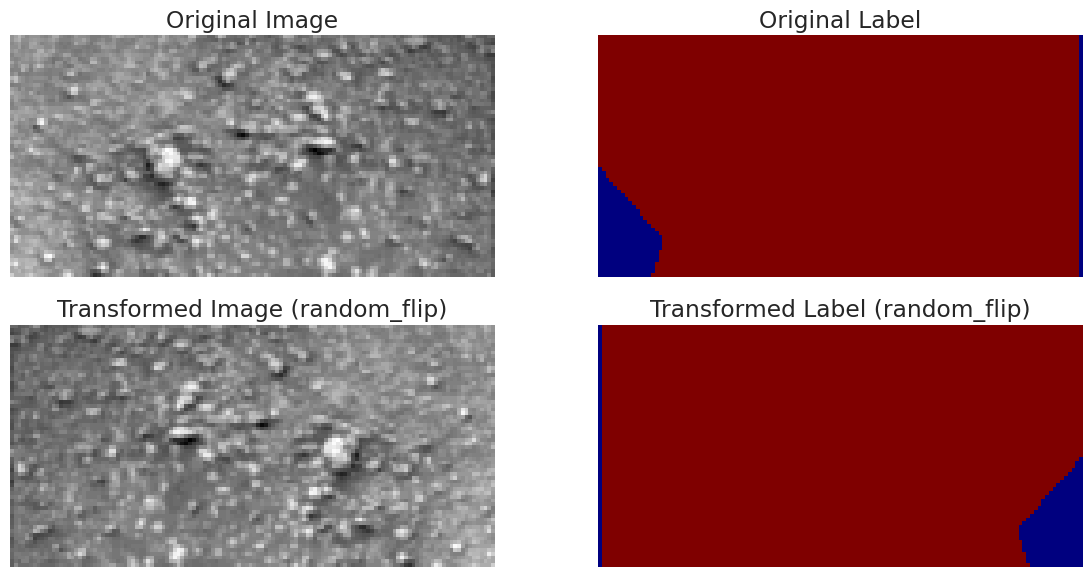

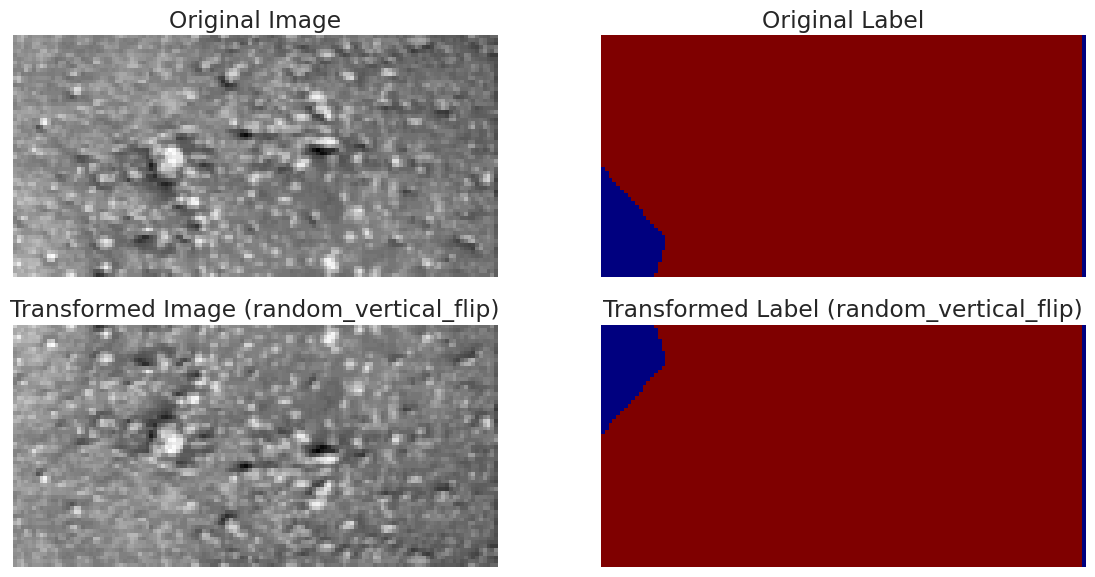

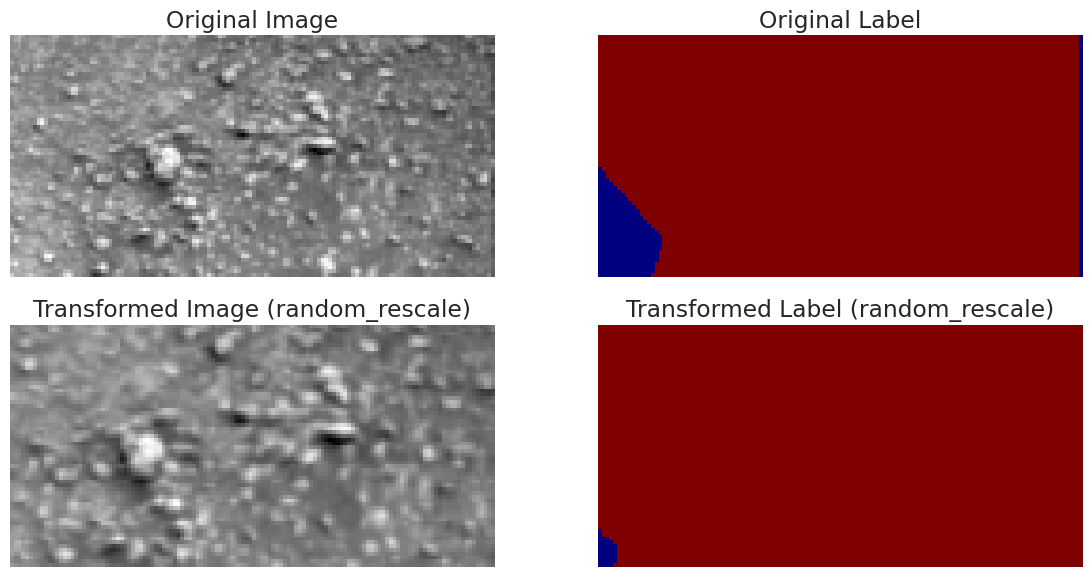

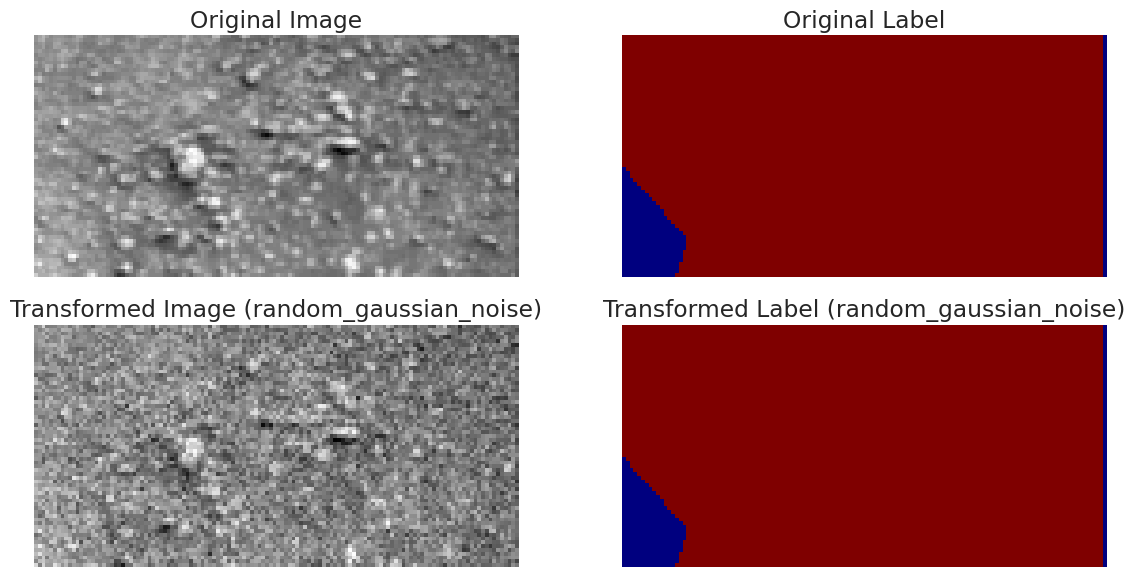

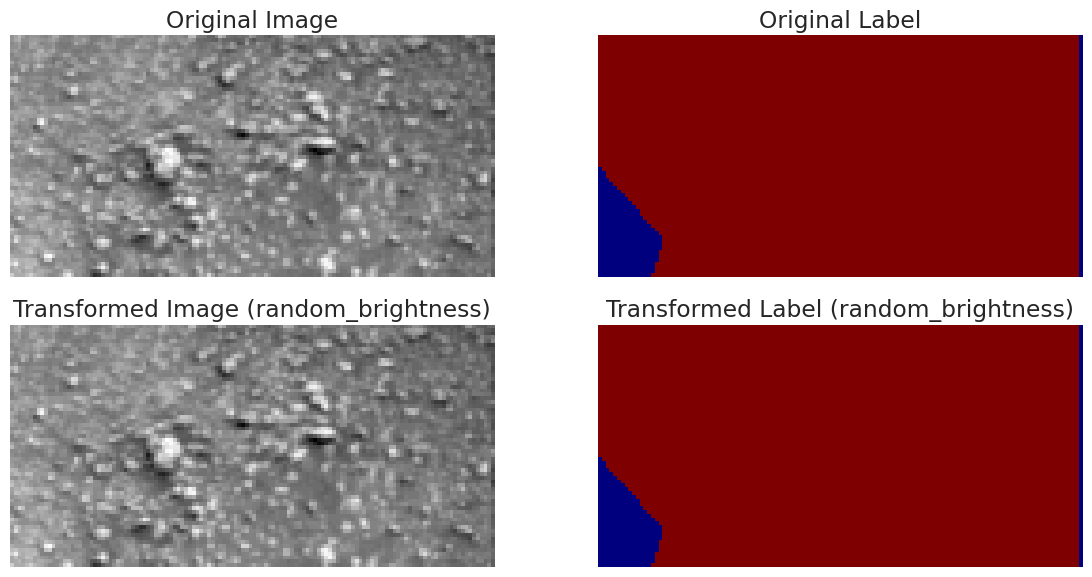

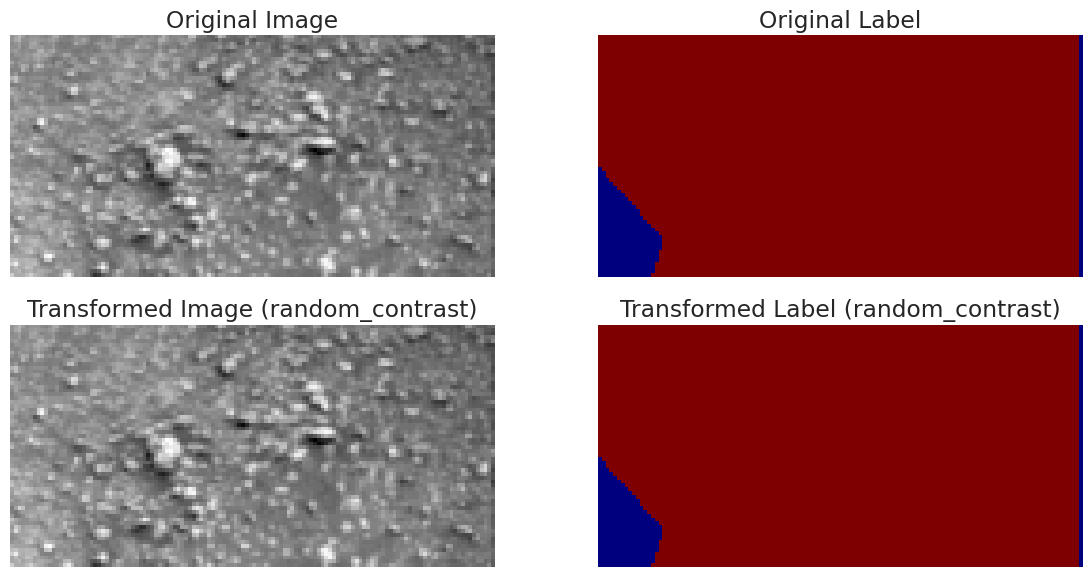

In [ ]:
# Visualize random horizontal flip
visualize_transformation(train_dataset, random_flip)

# Visualize random vertical flip
visualize_transformation(train_dataset, random_vertical_flip)

# Visualize random rescale
visualize_transformation(train_dataset, random_rescale, min_scale=1.0, max_scale=1.3)

# Visualize random Gaussian noise
visualize_transformation(train_dataset, random_gaussian_noise, mean=0.0, stddev=5.0)

# Visualize random brightness adjustment
visualize_transformation(train_dataset, random_brightness, max_delta=20)

# Visualize random contrast adjustment
visualize_transformation(train_dataset, random_contrast, lower=0.7, upper=1.3)

# Preprocessing

In [ ]:
def tile_dataset(dataset, image_shape, label_shape):
    """
    Tiles each image and segmentation label in the dataset into two halves along the width.

    Args:
    - dataset (tf.data.Dataset): A dataset of (image, label) pairs.
    - image_shape (tuple): The shape of each image (height, width, channels).
    - label_shape (tuple): The shape of each segmentation label (height, width, channels).

    Returns:
    - tf.data.Dataset: A new dataset with tiled images and labels.
    """
    def tile_image_label(image, label):
        # Split the image and label along the width (axis=1)
        image_tile1, image_tile2 = tf.split(image, num_or_size_splits=2, axis=1)
        label_tile1, label_tile2 = tf.split(label, num_or_size_splits=2, axis=1)

        # Combine the tiles into two new (image, label) pairs
        tiled1 = (image_tile1, label_tile1)
        tiled2 = (image_tile2, label_tile2)
        return tf.data.Dataset.from_tensors(tiled1).concatenate(tf.data.Dataset.from_tensors(tiled2))

    # Map the tile operation over the dataset
    tiled_dataset = dataset.flat_map(lambda image, label: tile_image_label(image, label))

    return tiled_dataset

def augment_and_concat(image, label, augment_geometrical=False, augment_noise=False, augment_texture=False, seed=None):
    """Apply augmentation and concatenate augmented version with original."""
    augmented_images = [image]
    augmented_labels = [label]

    if augment_geometrical:
        image_flip, label_flip = random_flip(image, label, seed=seed)
        image_vertical_flip, label_vertical_flip = random_vertical_flip(image, label, seed=seed)
        image_rotation, label_rotation = random_rotation(image, label, seed=seed)
        augmented_images.extend([image_flip, image_vertical_flip, image_rotation])
        augmented_labels.extend([label_flip, label_vertical_flip, label_rotation])

    if augment_noise:
        image_noise, _ = random_gaussian_noise(image, label, seed=seed)
        augmented_images.append(image_noise)
        augmented_labels.append(label)

    if augment_texture:
        image_brightness, _ = random_brightness(image, label, seed=seed)
        image_contrast, _ = random_contrast(image, label, seed=seed)

        augmented_images.extend([image_brightness, image_contrast])
        augmented_labels.extend([label, label])

    return augmented_images, augmented_labels

def make_dataset(
    dataset,
    augment_geometrical=False,
    augment_noise=False,
    augment_texture=False,
    batch_size=64,
    batching=True,
    seed=None
):
    """
    Applies augment_and_concat to each (image, segmentation_label) pair in a dataset
    and returns a new dataset containing all augmented versions.

    Args:
    - dataset: tf.data.Dataset, a dataset of (image, segmentation_label) pairs.
    - augment_geometrical: Whether to apply geometrical augmentations (flip, rotate, etc.).
    - augment_noise: Whether to apply noise augmentations (Gaussian noise).
    - augment_texture: Whether to apply texture augmentations (brightness, contrast).
    - seed: Seed for reproducibility.

    Returns:
    - tf.data.Dataset: A new dataset containing all original and augmented versions.
    """
    def process_image_label(image, label):
        # Apply augmentations and get the augmented images and labels
        augmented_images, augmented_labels = augment_and_concat(
            image, label,
            augment_geometrical=augment_geometrical,
            augment_noise=augment_noise,
            augment_texture=augment_texture,
            seed=seed
        )
        # Stack augmented images and labels into a dataset
        augmented_dataset = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
        return augmented_dataset

    def augment_and_flat_map(image, label):
        # Process each (image, label) and return the resulting dataset
        return process_image_label(image, label)

    # Apply augment_and_flat_map to each (image, label) in the dataset and flatten the result
    augmented_dataset = dataset.flat_map(augment_and_flat_map)
    augmented_dataset = augmented_dataset.shuffle(buffer_size=50000).batch(batch_size)
    return augmented_dataset

def compute_dataset_statistics(dataset):
    """Compute mean and std of the dataset."""
    mean = tf.constant(0.0, dtype=tf.float32)  # Ensure mean is float32
    std = tf.constant(0.0, dtype=tf.float32)  # Ensure std is float32
    count = tf.constant(0.0, dtype=tf.float32)

    for image, _ in dataset:
        image = tf.cast(image, tf.float32)  # Ensure image is float32
        mean += tf.reduce_sum(image)
        count += tf.cast(tf.size(image), tf.float32)

    mean = mean / count

    for image, _ in dataset:
        image = tf.cast(image, tf.float32)  # Ensure image is float32
        std += tf.reduce_sum((image - mean) ** 2)

    std = tf.sqrt(std / count)
    return mean, std

def normalize_dynamic(image, label, mean, std):
    """Normalize image dynamically using mean and std."""
    image = tf.cast(image, tf.float32)
    image = (image - mean) / (std + 1e-8)  # Add epsilon to avoid division by zero
    return image, label

def normalize_dynamic_nolbl(image, mean, std):
    """Normalize image dynamically using mean and std for dataset without labels."""
    image = tf.cast(image, tf.float32)
    image = (image - mean) / (std + 1e-8)  # Add epsilon to avoid division by zero
    return image

# Extract images (X_train) and labels (y_train) from the dataset
def to_np(dataset):
    # Initialize an empty list to store images
    X_np = []
    for x in dataset.as_numpy_iterator():
        X_np.append(x)

    # Convert lists to NumPy arrays
    X_np = np.array(X_np)
    print("X_train_np shape:", X_np.shape)
    return X_np

# To pandas dataframe
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Tile the datasets
TILING_SHAPE = (64, 64, 1)
train_dataset = tile_dataset(train_dataset, TILING_SHAPE, TILING_SHAPE)
val_dataset = tile_dataset(val_dataset, TILING_SHAPE, TILING_SHAPE)
test_dataset = tile_dataset(test_dataset, TILING_SHAPE, TILING_SHAPE)

# Base Architecture

In [ ]:
# Define custom Mean Intersection Over Union metric
@tf.keras.utils.register_keras_serializable()
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [ ]:
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(y_true, y_pred):
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weights = alpha * tf.pow(1 - y_pred, gamma)
        focal_loss = tf.reduce_sum(weights * cross_entropy, axis=-1)
        return tf.reduce_mean(focal_loss)
    return loss_fn

The original U-Net paper demonstrates the effectiveness of skip connections in preserving spatial information lost during downsampling. This makes U-Net more sensitive to fine-grained details, which is crucial when comparing the effects of different preprocessing techniques (e.g., augmentations or noise injections). Without skip connections, the model might not fully exploit the improved spatial details provided by preprocessing, making it harder to evaluate the true impact of these techniques.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Parameters
INPUT_SHAPE = TILING_SHAPE
NUM_CLASSES = 5
LEARNING_RATE = 1e-4
EPOCHS = 50
PATIENCE = 5
BATCH_SIZE = 32
loss = focal_loss()

# Callbacks
lr_reduction = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=PATIENCE,
    min_lr=1e-6,
    factor=0.2,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=EPOCHS,
    restore_best_weights=True
)
callbacks = [lr_reduction, early_stopping]

In [ ]:
import json
import datetime
from tensorflow.keras.callbacks import ModelCheckpoint

# Define U-Net block
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

# Define U-Net model
def unet(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [ ]:
def train_unet(loss_fn, train_dataset, val_dataset, model_name='UNet'):
    global LEARNING_RATE, EPOCHS, NUM_CLASSES, callbacks

    # Create the model
    model = unet()

    # Compile the model
    model.compile(
        loss=loss_fn,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
    )

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=callbacks,
        verbose=1
    ).history

    # Calculate the final validation MeanIoU
    final_val_meanIoU = round(max(history.get('val_mean_iou', [0])) * 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

    # Create a timestamp for unique file naming
    timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    # Save the model with the accuracy in the filename
    model_filename = f'{model_name}_{loss_fn.__class__.__name__}_{final_val_meanIoU}_{timestamp}.keras'
    model.save(model_filename)
    print(f'Model saved as {model_filename}')

    # Save training history as a JSON file
    history_filename = f"history_{model_name}_{loss_fn.__class__.__name__}_{timestamp}.json"
    with open(history_filename, 'w') as f:
        json.dump(history, f)
    print(f"Training history saved as {history_filename}")

    # Delete the model to free up resources
    del model

    # Return the history dictionary
    return history, model_filename

In [ ]:
def plot_history(history, loss_fn):
    """
    Plots training and validation loss, accuracy, and mean IoU from the training history.

    Parameters:
    history (dict): The training history containing 'loss', 'val_loss', 'accuracy', 'val_accuracy',
                    'mean_iou', and 'val_mean_iou'.
    loss_fn (str): The loss function used in the training (e.g., 'SparseCategoricalCrossentropy').
    """
    metrics = {
        "Loss (" + loss_fn.__class__.__name__ + ")": ("loss", "val_loss"),
        "Accuracy": ("accuracy", "val_accuracy"),
        "Mean Intersection Over Union": ("mean_iou", "val_mean_iou")
    }

    # Plot the metrics
    for title, (train_key, val_key) in metrics.items():
        plt.figure(figsize=(18, 3))
        plt.plot(history[train_key], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
        plt.plot(history[val_key], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
        plt.title(title)
        plt.legend()
        plt.grid(alpha=0.3)
        plt.show()

In [ ]:
from matplotlib.colors import ListedColormap

# Define class labels and colormap
CLASS_LABELS = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
COLORS = ["black", "brown", "gray", "yellow", "darkred"]
cmap = ListedColormap(COLORS)

def plot_triptychs(dataset, model, num_samples=1, seed=42):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    seed: int - Random seed for shuffling the dataset
    """
    # Shuffle the dataset and then take `num_samples` random samples
    shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=seed)
    samples = shuffled_dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0], cmap='gray')  # Assuming grayscale images
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        axes[1].imshow(labels[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        im = axes[2].imshow(pred[0], cmap=cmap, vmin=0, vmax=len(CLASS_LABELS)-1)
        axes[2].axis('off')

        # Add a color legend for the segmentation classes
        cbar = plt.colorbar(im, ax=axes[2], fraction=0.022, pad=0.04)
        cbar.set_ticks(range(len(CLASS_LABELS)))
        cbar.set_ticklabels([CLASS_LABELS[i] for i in range(len(CLASS_LABELS))])

        plt.tight_layout()
        plt.show()
        plt.close()

In [ ]:
def contains_big_rock(images, label):
    """
    Check if the label contains the undersampled class 'Big Rock' (class label 4).

    Parameters:
    label: tf.Tensor - The label tensor

    Returns:
    bool - True if the label contains 'Big Rock', otherwise False
    """
    return tf.reduce_any(label == 4)

# Different Augmentation Combinations

## Baseline (no augmentations)

Part of the notebook copied from class_imbalance. The baseline is the same as the one tested with focal loss but it was trained with 500 epochs. The only thing that is going to change now is the epoches for others.

Epoch 1/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.3300 - loss: 0.2703 - mean_iou: 0.1498 - val_accuracy: 0.4874 - val_loss: 0.2050 - val_mean_iou: 0.2610 - learning_rate: 1.0000e-04
Epoch 2/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.5249 - loss: 0.1797 - mean_iou: 0.2648 - val_accuracy: 0.5727 - val_loss: 0.1620 - val_mean_iou: 0.3101 - learning_rate: 1.0000e-04
Epoch 3/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5840 - loss: 0.1535 - mean_iou: 0.3100 - val_accuracy: 0.6113 - val_loss: 0.1449 - val_mean_iou: 0.3317 - learning_rate: 1.0000e-04
Epoch 4/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.5864 - loss: 0.1431 - mean_iou: 0.3166 - val_accuracy: 0.6425 - val_loss: 0.1257 - val_mean_iou: 0.3489 - learning_rate: 1.0000e-04
Epoch 5/500
220/220 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5916 - loss: 0.1389 - mean_iou: 0.3164 - val_accuracy: 0.6424 - val_loss: 0.1218 - val_mean_iou: 0.3502 - learning_rate: 1.0000e-0

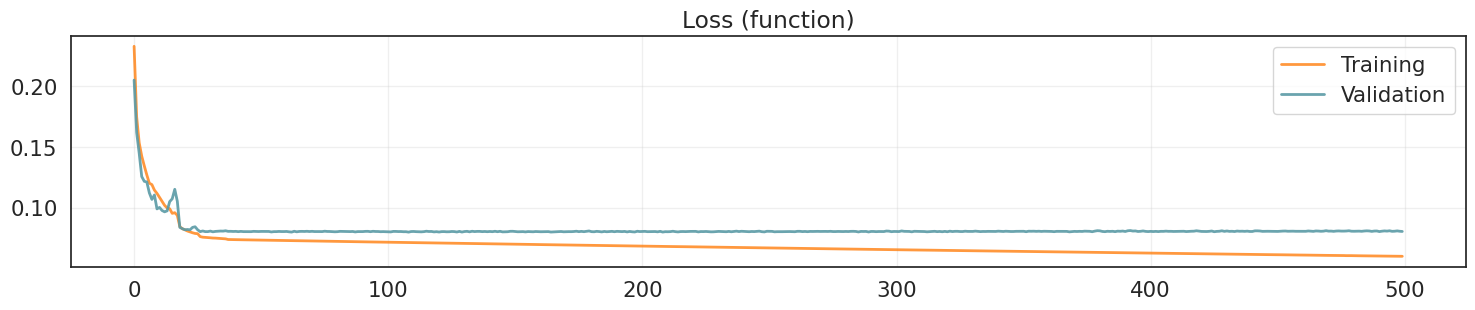

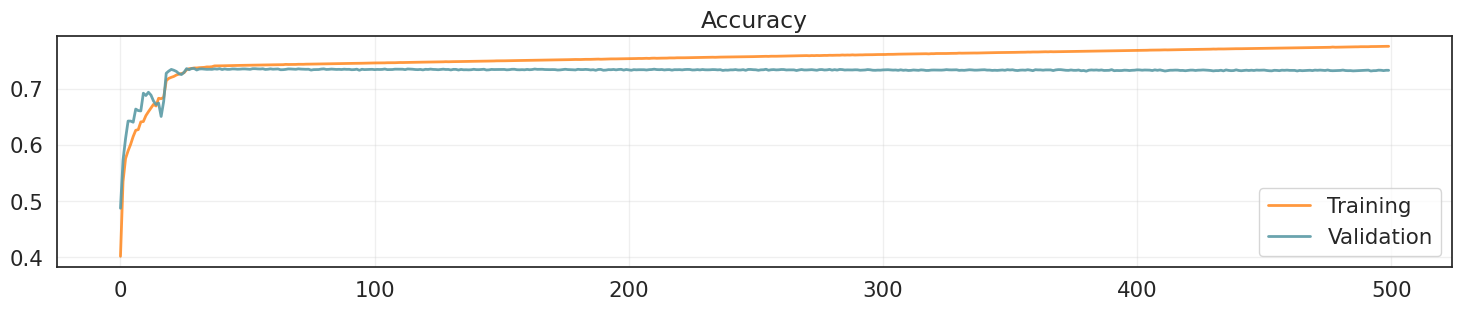

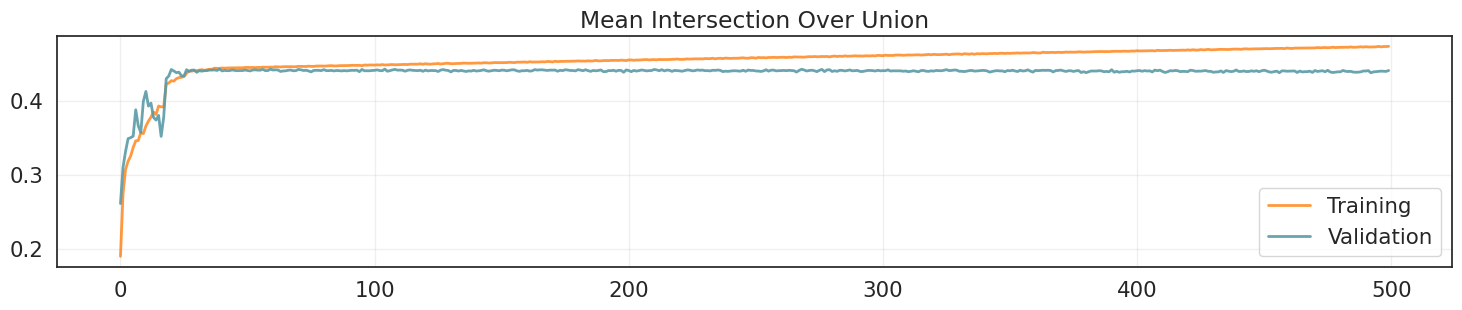

In [ ]:
plot_history(train(loss_fn=loss, train_dataset=train_dataset, val_dataset=val_dataset), loss)

Test Accuracy: 0.7156
Test Mean Intersection over Union: 0.4235


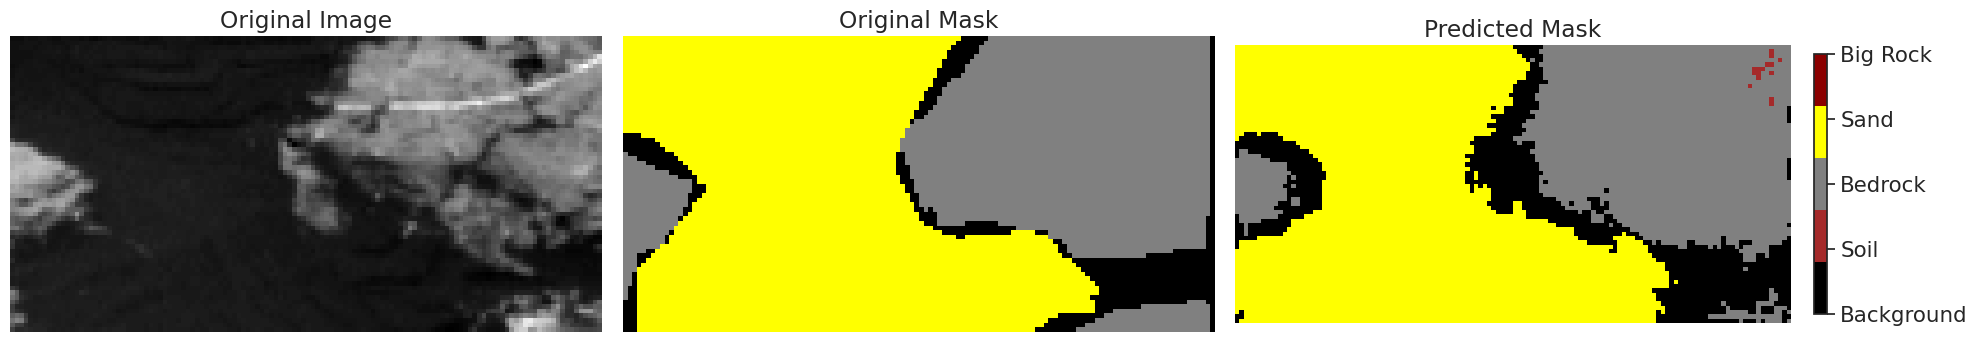

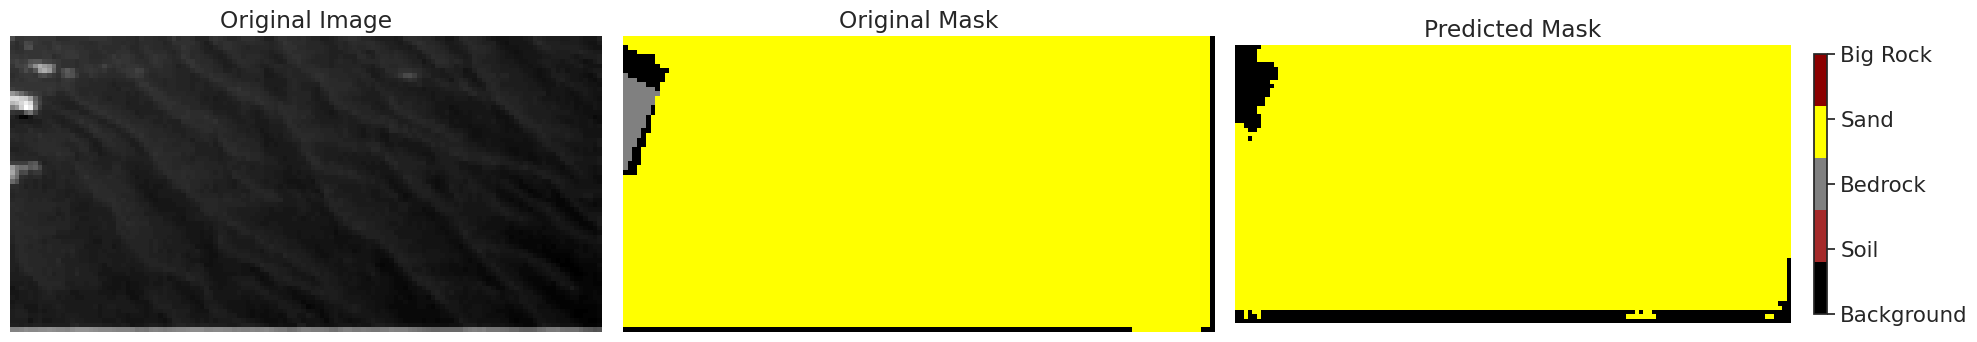

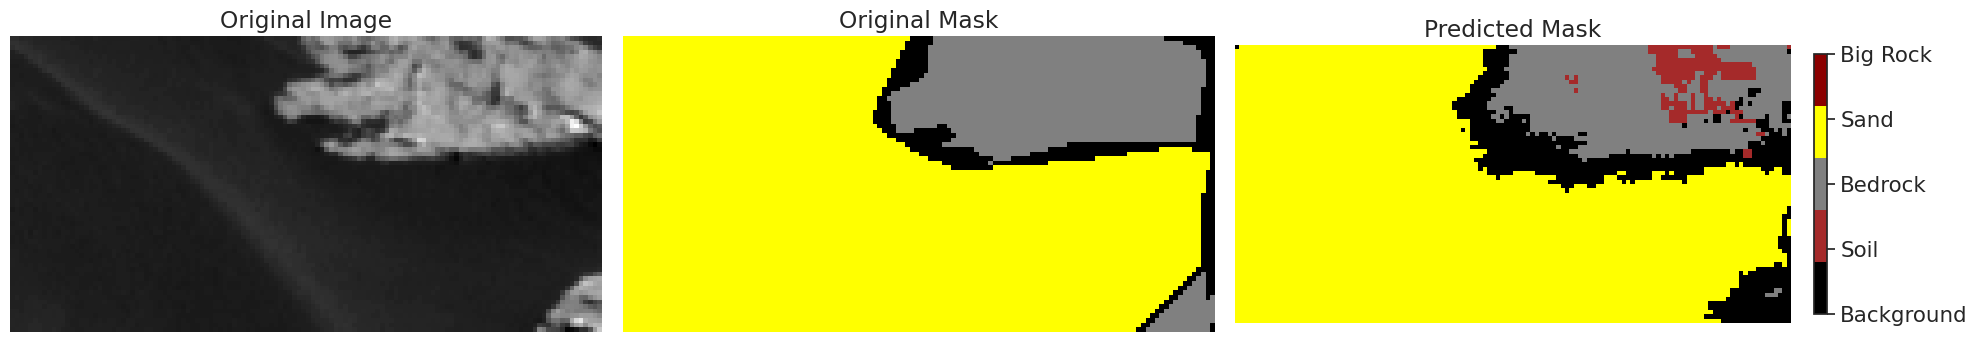

In [ ]:
# Load model
model = tfk.models.load_model(os.path.join('loss_functions', 'UNet_function_44.31_20241201-214145.keras'), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=focal_loss(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=3)

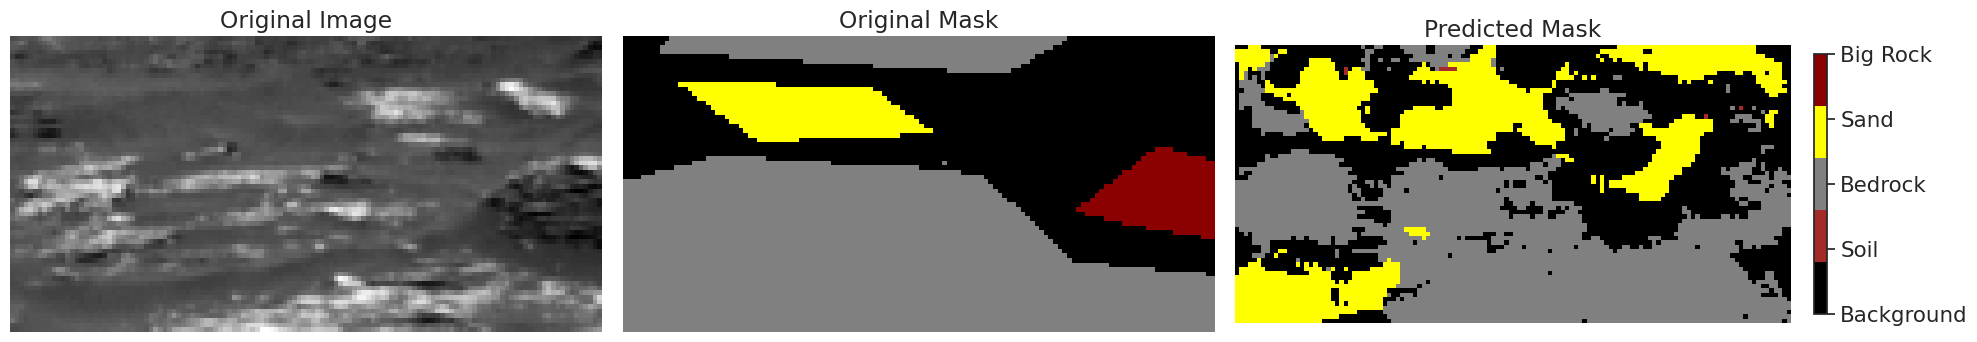

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=seed)

## Geometrical + Noise

In [ ]:
# Augmentation, applied to train, validation and test
augment_geometrical = True
augment_noise = True
augment_texture = False

train_dataset1 = make_dataset(
      dataset=train_dataset,
      augment_geometrical=augment_geometrical,
      augment_noise=augment_noise,
      augment_texture=augment_texture,
      batch_size=BATCH_SIZE,
      seed=seed
  )
val_dataset1 = make_dataset(
    dataset=val_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)
test_dataset1 = make_dataset(
    dataset=test_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)

# Compute statistics on the training dataset
mean, std = compute_dataset_statistics(train_dataset1)

# Apply dynamic normalization to datasets
train_dataset1 = train_dataset1.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
val_dataset1 = val_dataset1.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
test_dataset1 = test_dataset1.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
final_test_dataset1 = final_test_dataset.map(lambda img: normalize_dynamic_nolbl(img, mean, std))

# Filter the test dataset to include only samples containing 'Big Rock'
filtered_test_dataset = test_dataset1.unbatch().filter(lambda image, label: contains_big_rock(image, label)).batch(BATCH_SIZE)

In [ ]:
history, model_filename = train_unet(loss_fn=loss, train_dataset=train_dataset1, val_dataset=val_dataset1, model_name="GeomNoise")

Epoch 1/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 57s 65ms/step - accuracy: 0.4812 - loss: 0.2041 - mean_iou: 0.2423 - val_accuracy: 0.6490 - val_loss: 0.1266 - val_mean_iou: 0.3732 - learning_rate: 1.0000e-04
Epoch 2/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.6297 - loss: 0.1248 - mean_iou: 0.3477 - val_accuracy: 0.6790 - val_loss: 0.1068 - val_mean_iou: 0.3849 - learning_rate: 1.0000e-04
Epoch 3/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6499 - loss: 0.1104 - mean_iou: 0.3637 - val_accuracy: 0.6892 - val_loss: 0.0965 - val_mean_iou: 0.3923 - learning_rate: 1.0000e-04
Epoch 4/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.6653 - loss: 0.1027 - mean_iou: 0.3764 - val_accuracy: 0.6644 - val_loss: 0.1047 - val_mean_iou: 0.3738 - learning_rate: 1.0000e-04
Epoch 5/50
549/549 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6793 - loss: 0.0963 - mean_iou: 0.3869 - val_accuracy: 0.6507 - val_loss: 0.1073 - val_mean_iou: 0.3488 - learning_rate: 1.0000e-04


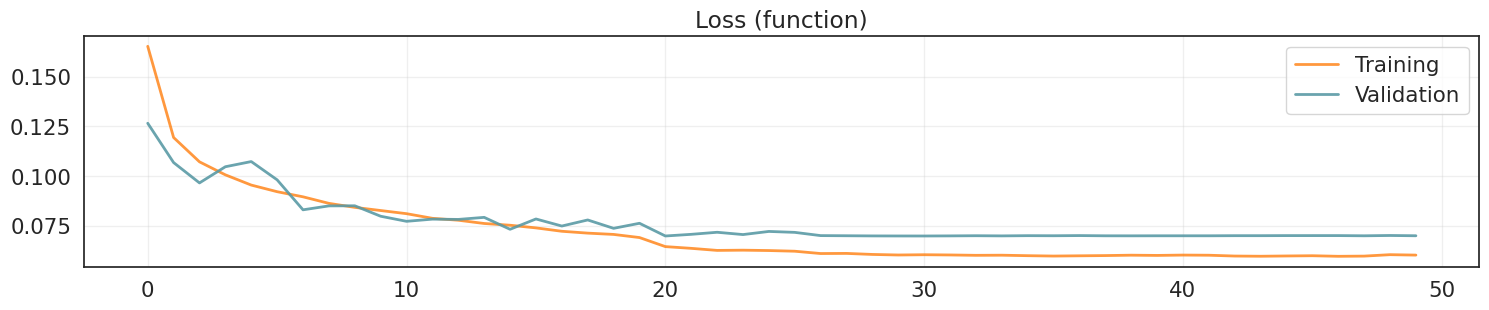

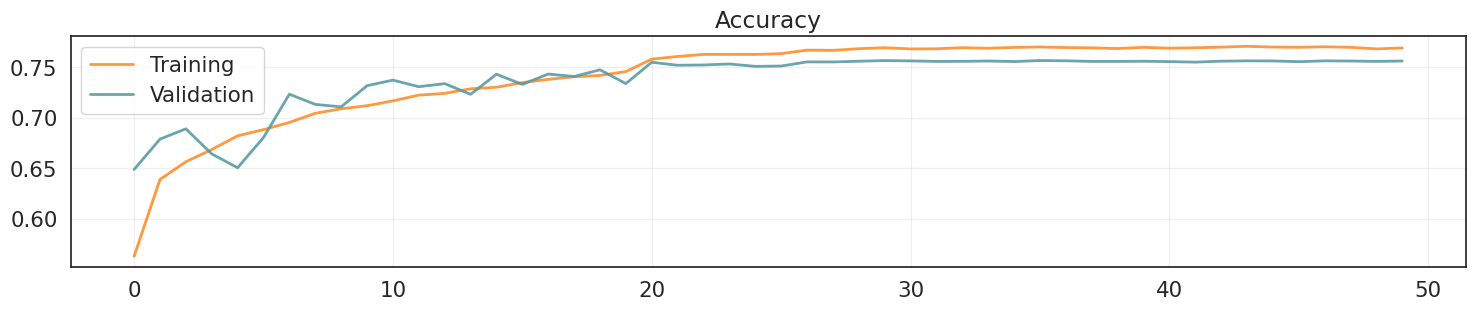

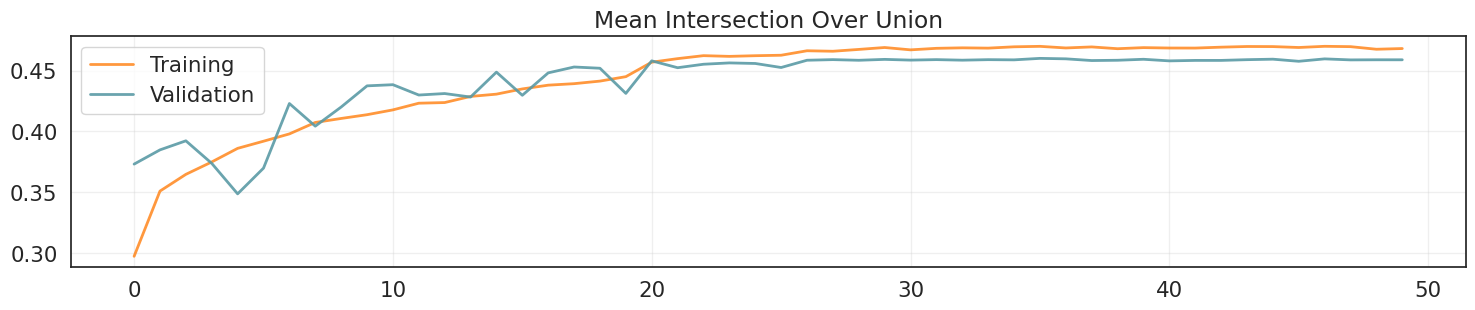

In [ ]:
plot_history(history, loss)

Test Accuracy: 0.7394
Test Mean Intersection over Union: 0.4455


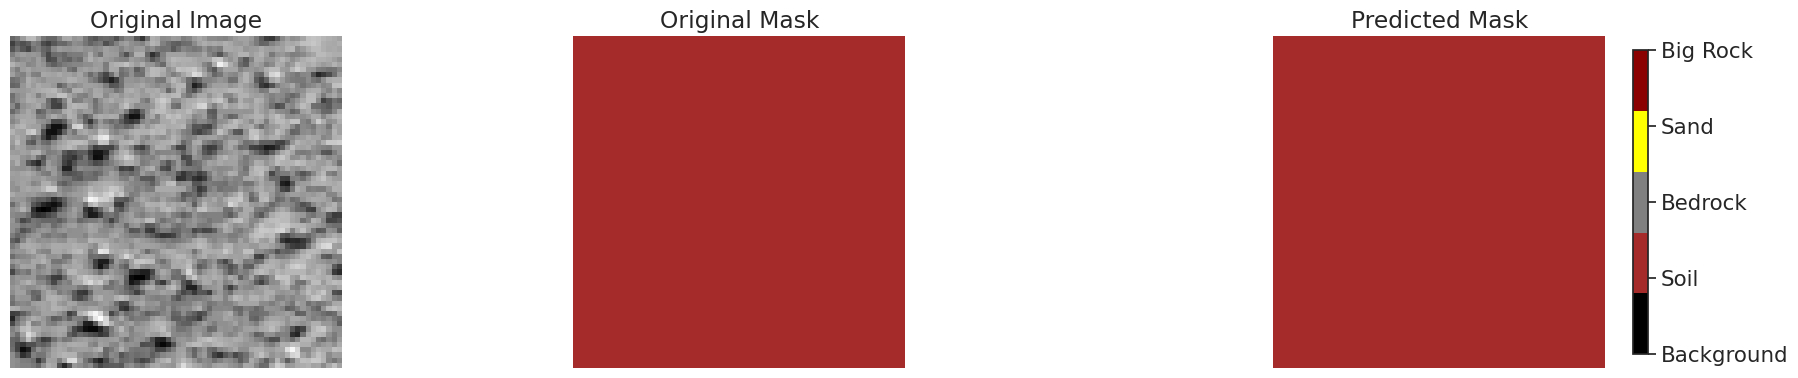

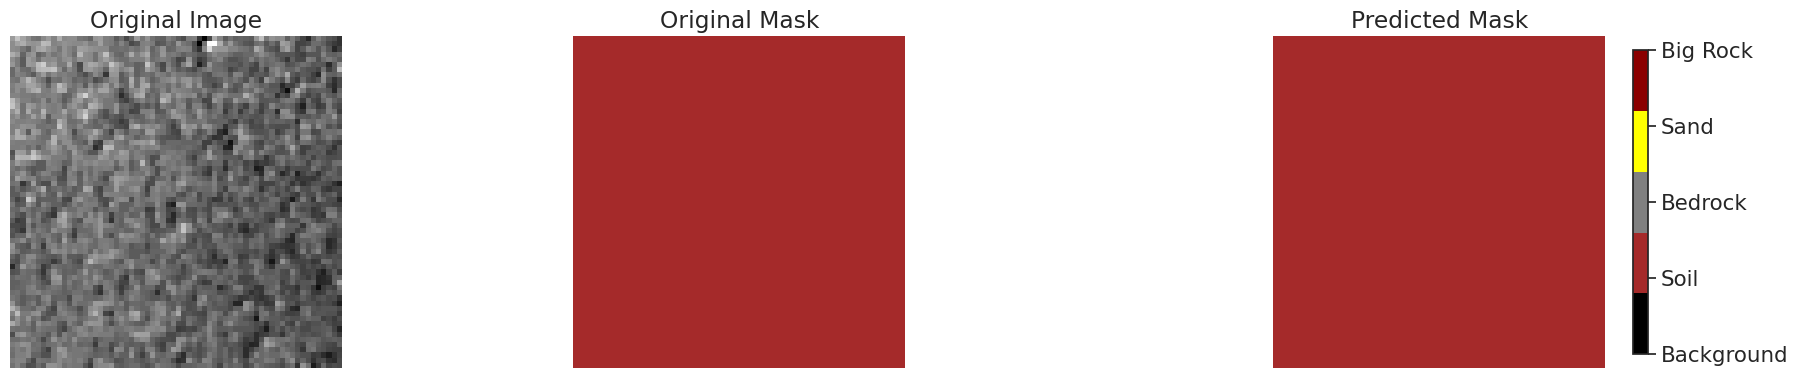

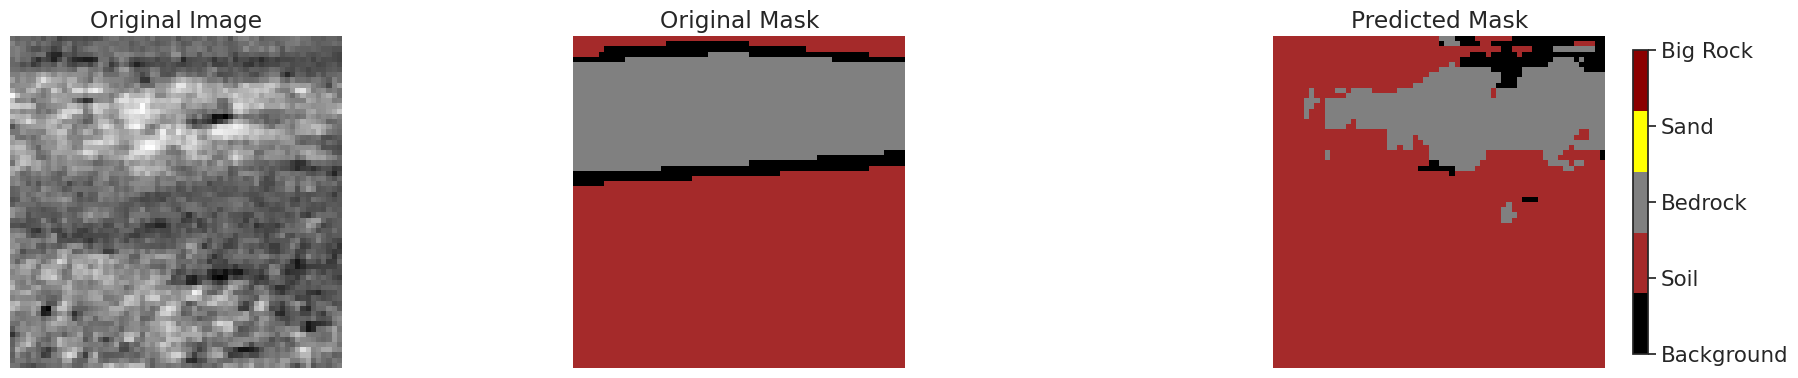

In [ ]:
# Load model
model_filename = 'GeomNoise_function_46.0_20241207-192021.keras'
model = tfk.models.load_model(os.path.join('data_augmentations', model_filename), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=focal_loss(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset1, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset1, model, num_samples=3)

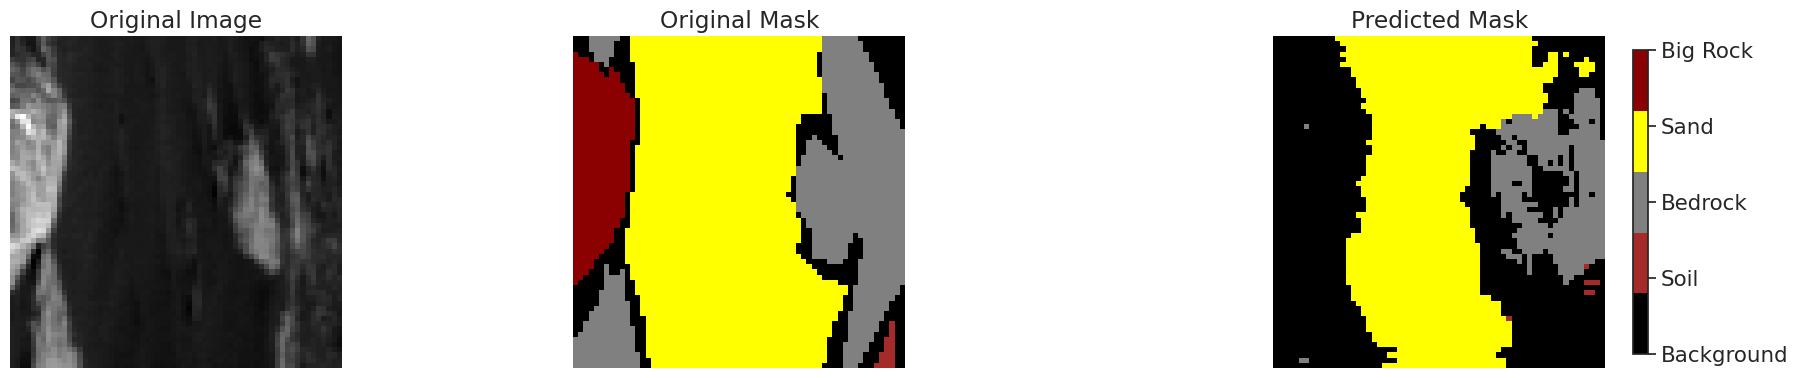

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=seed)

In [ ]:
# Turn into np
X_final_test = to_np(final_test_dataset1)

# Compute predictions
predictions = model.predict(X_final_test)
predictions = np.argmax(predictions, axis=-1)

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(predictions)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

X_train_np shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Noise + Texture

In [ ]:
# Augmentation, applied to train, validation and test
augment_geometrical = False
augment_noise = True
augment_texture = True

train_dataset2 = make_dataset(
      dataset=train_dataset,
      augment_geometrical=augment_geometrical,
      augment_noise=augment_noise,
      augment_texture=augment_texture,
      batch_size=BATCH_SIZE,
      seed=seed
  )
val_dataset2 = make_dataset(
    dataset=val_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)
test_dataset2 = make_dataset(
    dataset=test_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)

# Compute statistics on the training dataset
mean, std = compute_dataset_statistics(train_dataset2)

# Apply dynamic normalization to datasets
train_dataset2 = train_dataset2.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
val_dataset2 = val_dataset2.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
test_dataset2 = test_dataset2.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
final_test_dataset2 = final_test_dataset.map(lambda img: normalize_dynamic_nolbl(img, mean, std))

# Filter the test dataset to include only samples containing 'Big Rock'
filtered_test_dataset = test_dataset2.unbatch().filter(lambda image, label: contains_big_rock(image, label)).batch(BATCH_SIZE)

In [ ]:
history, model_filename = train_unet(loss_fn=loss, train_dataset=train_dataset2, val_dataset=val_dataset2, model_name="NoiText")

Epoch 1/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 49s 76ms/step - accuracy: 0.4919 - loss: 0.1855 - mean_iou: 0.2446 - val_accuracy: 0.5086 - val_loss: 0.1678 - val_mean_iou: 0.2435 - learning_rate: 1.0000e-04
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 56s 35ms/step - accuracy: 0.6114 - loss: 0.1227 - mean_iou: 0.3399 - val_accuracy: 0.6315 - val_loss: 0.1174 - val_mean_iou: 0.3669 - learning_rate: 1.0000e-04
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6428 - loss: 0.1097 - mean_iou: 0.3600 - val_accuracy: 0.6751 - val_loss: 0.1025 - val_mean_iou: 0.3944 - learning_rate: 1.0000e-04
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.6601 - loss: 0.1021 - mean_iou: 0.3755 - val_accuracy: 0.6973 - val_loss: 0.0955 - val_mean_iou: 0.4051 - learning_rate: 1.0000e-04
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6741 - loss: 0.0971 - mean_iou: 0.3884 - val_accuracy: 0.6852 - val_loss: 0.0990 - val_mean_iou: 0.3874 - learning_rate: 1.0000e-04


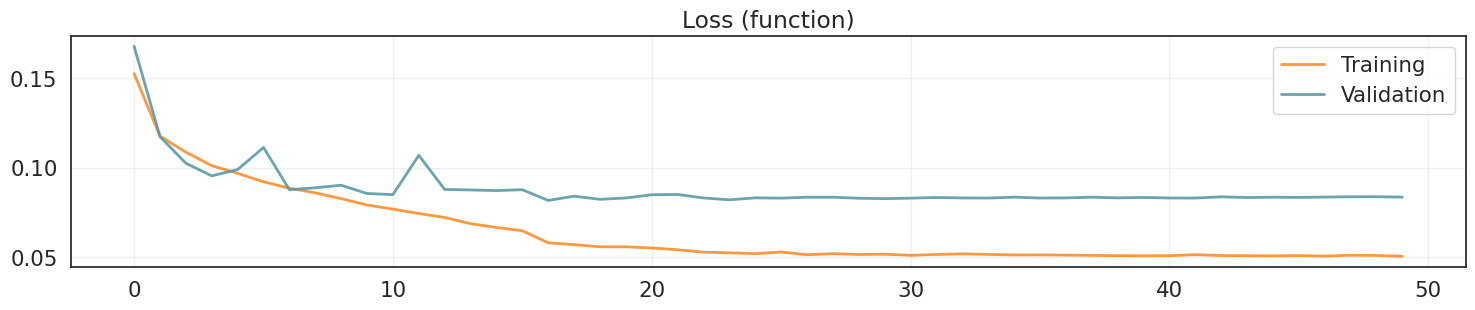

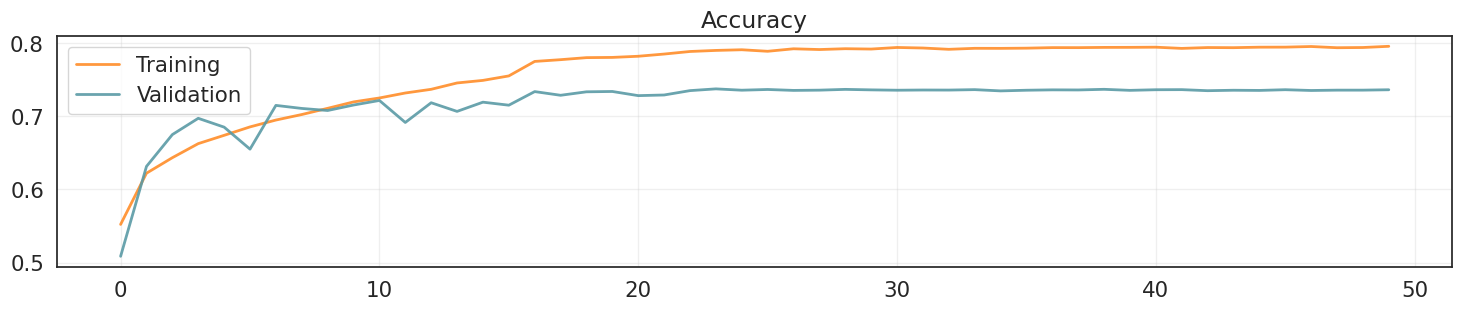

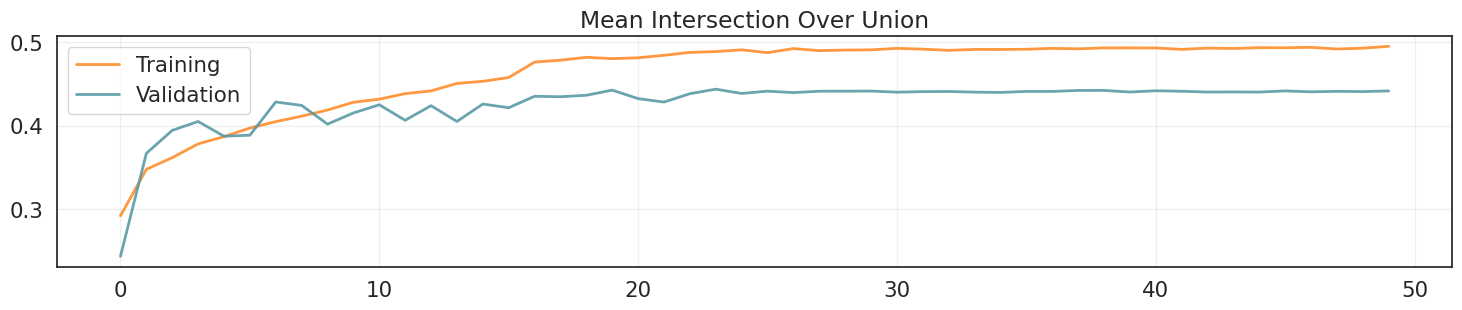

In [ ]:
plot_history(history, loss)

Test Accuracy: 0.4866
Test Mean Intersection over Union: 0.2298


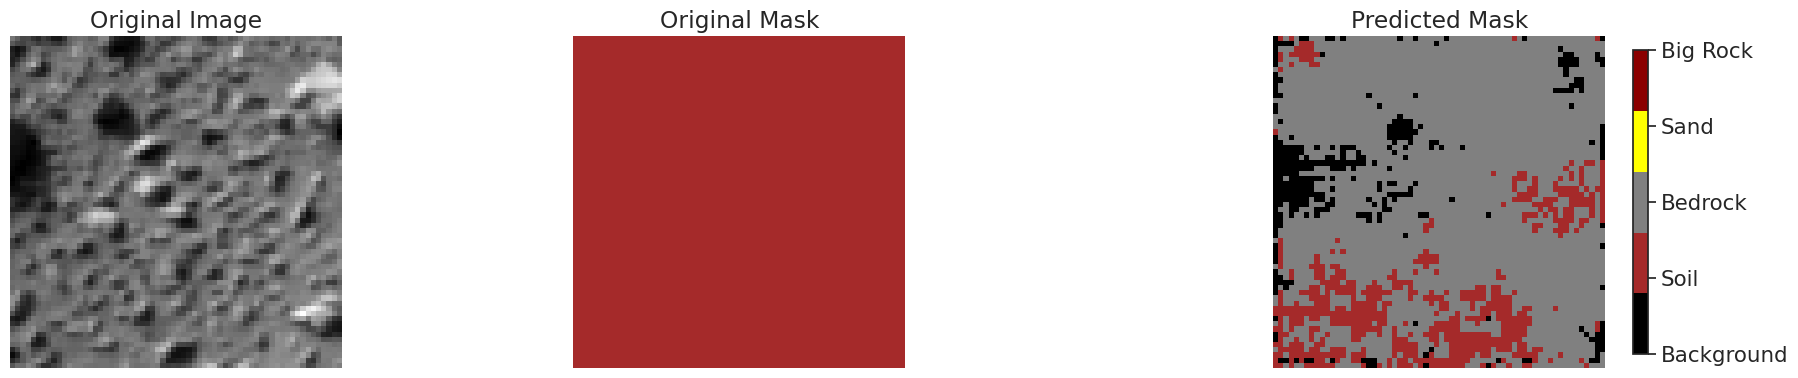

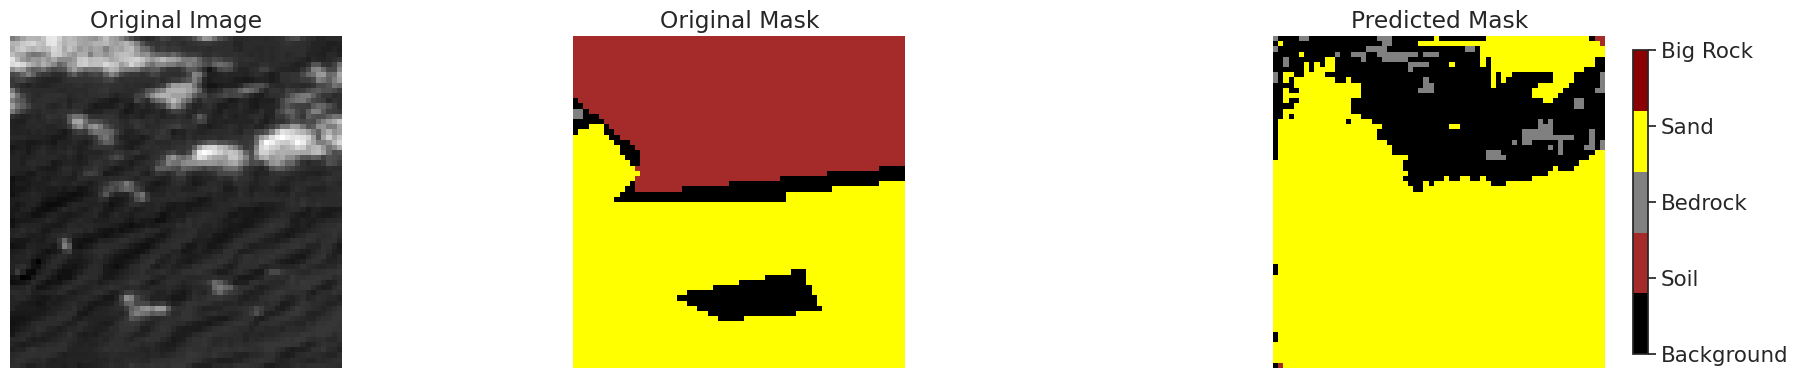

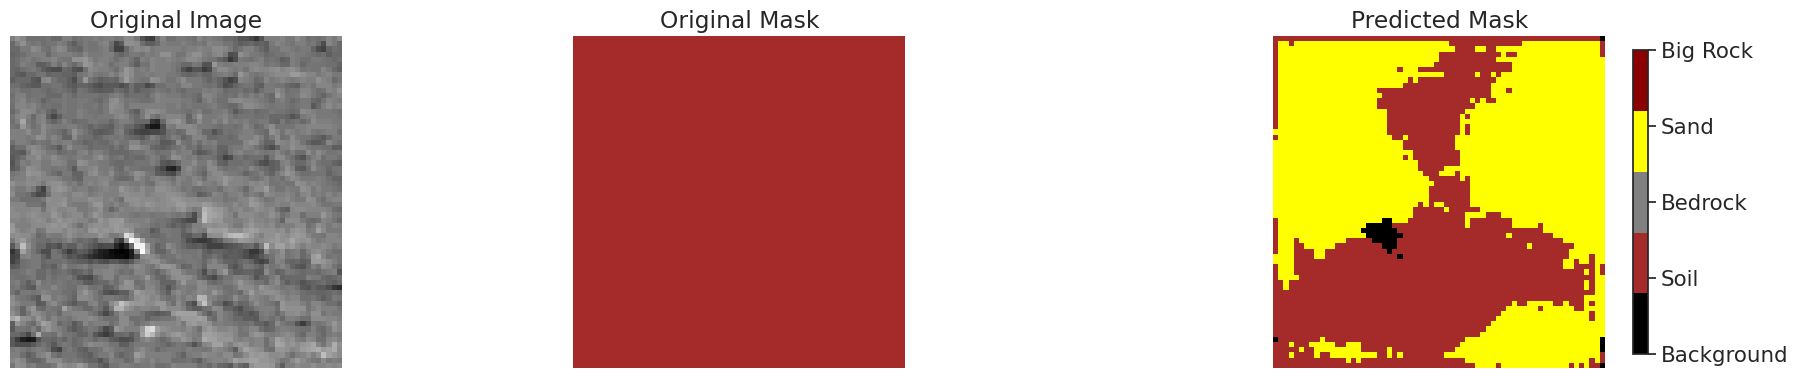

In [ ]:
# Load model
model_filename = 'NoiText_function_44.38_20241207-193711.keras'
model = tfk.models.load_model(os.path.join('data_augmentations', model_filename), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=focal_loss(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset2, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset2, model, num_samples=3)

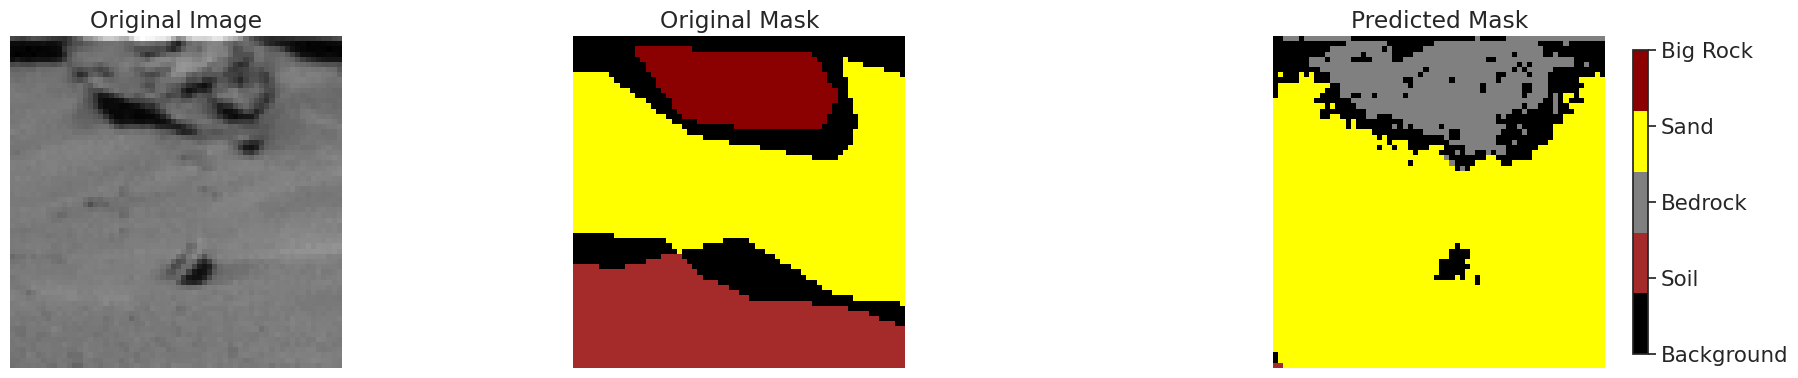

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=seed)

In [ ]:
# Turn into np
X_final_test = to_np(final_test_dataset2)

# Compute predictions
predictions = model.predict(X_final_test)
predictions = np.argmax(predictions, axis=-1)

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(predictions)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

X_train_np shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Texture + Geometrical

In [ ]:
# Augmentation, applied to train, validation and test
augment_geometrical = True
augment_noise = False
augment_texture = True

train_dataset3 = make_dataset(
      dataset=train_dataset,
      augment_geometrical=augment_geometrical,
      augment_noise=augment_noise,
      augment_texture=augment_texture,
      batch_size=BATCH_SIZE,
      seed=seed
  )
val_dataset3 = make_dataset(
    dataset=val_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)
test_dataset3 = make_dataset(
    dataset=test_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)

# Compute statistics on the training dataset
mean, std = compute_dataset_statistics(train_dataset3)

# Apply dynamic normalization to datasets
train_dataset3 = train_dataset3.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
val_dataset3 = val_dataset3.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
test_dataset3 = test_dataset3.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
final_test_dataset3 = final_test_dataset.map(lambda img: normalize_dynamic_nolbl(img, mean, std))

# Filter the test dataset to include only samples containing 'Big Rock'
filtered_test_dataset = test_dataset3.unbatch().filter(lambda image, label: contains_big_rock(image, label)).batch(BATCH_SIZE)

In [ ]:
history, model_filename = train_unet(loss_fn=loss, train_dataset=train_dataset3, val_dataset=val_dataset3, model_name="TextGeom")

Epoch 1/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 55s 58ms/step - accuracy: 0.4960 - loss: 0.1862 - mean_iou: 0.2614 - val_accuracy: 0.6404 - val_loss: 0.1204 - val_mean_iou: 0.3662 - learning_rate: 1.0000e-04
Epoch 2/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 60s 36ms/step - accuracy: 0.6411 - loss: 0.1149 - mean_iou: 0.3603 - val_accuracy: 0.6884 - val_loss: 0.0976 - val_mean_iou: 0.4035 - learning_rate: 1.0000e-04
Epoch 3/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.6612 - loss: 0.1038 - mean_iou: 0.3723 - val_accuracy: 0.6978 - val_loss: 0.0912 - val_mean_iou: 0.3970 - learning_rate: 1.0000e-04
Epoch 4/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 42s 36ms/step - accuracy: 0.6800 - loss: 0.0958 - mean_iou: 0.3903 - val_accuracy: 0.7030 - val_loss: 0.0915 - val_mean_iou: 0.4116 - learning_rate: 1.0000e-04
Epoch 5/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step - accuracy: 0.6841 - loss: 0.0939 - mean_iou: 0.3944 - val_accuracy: 0.7111 - val_loss: 0.0876 - val_mean_iou: 0.4263 - learning_rate: 1.0000e-04


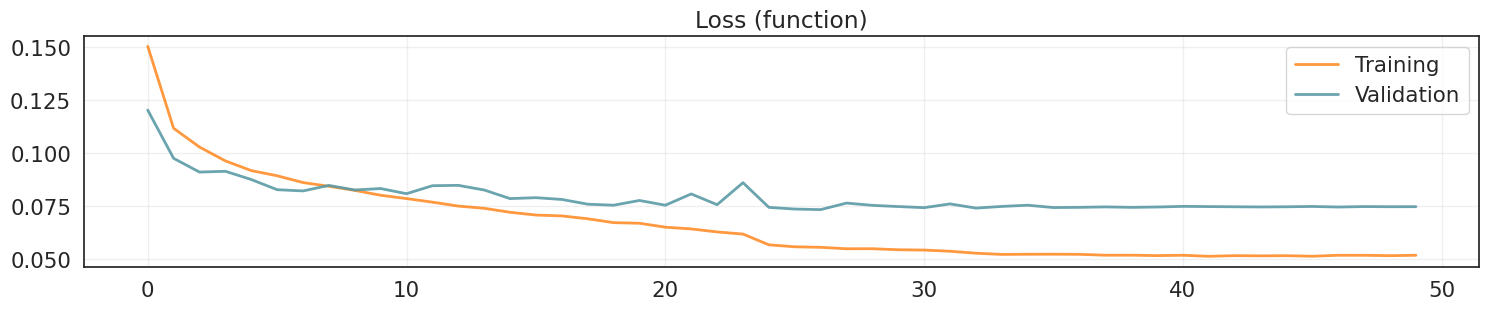

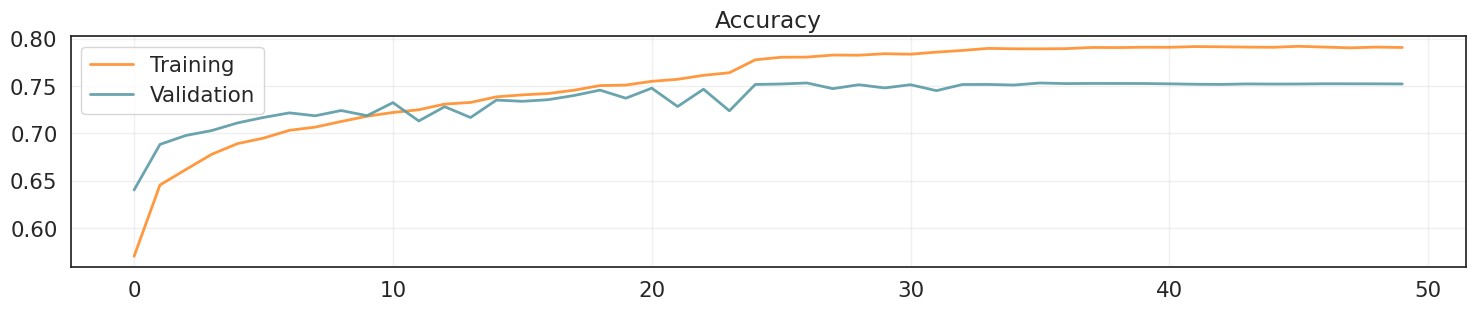

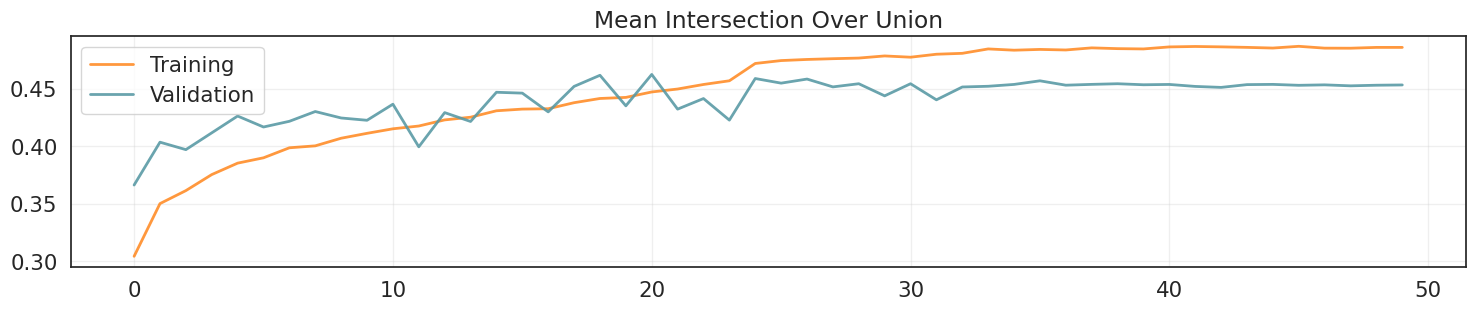

In [ ]:
plot_history(history, loss)

Test Accuracy: 0.6259
Test Mean Intersection over Union: 0.3502


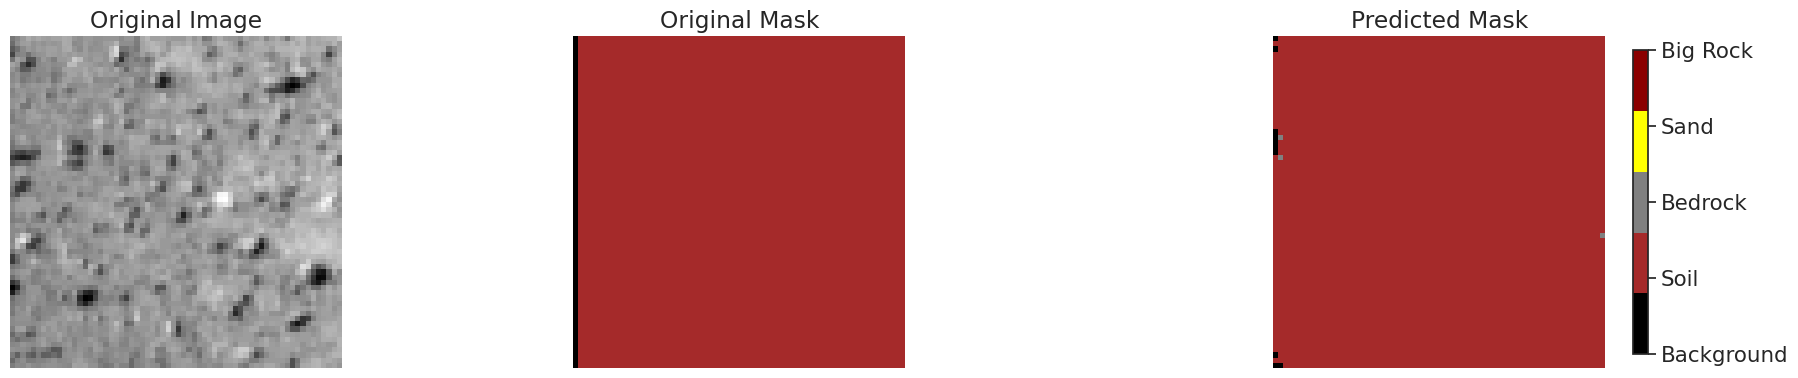

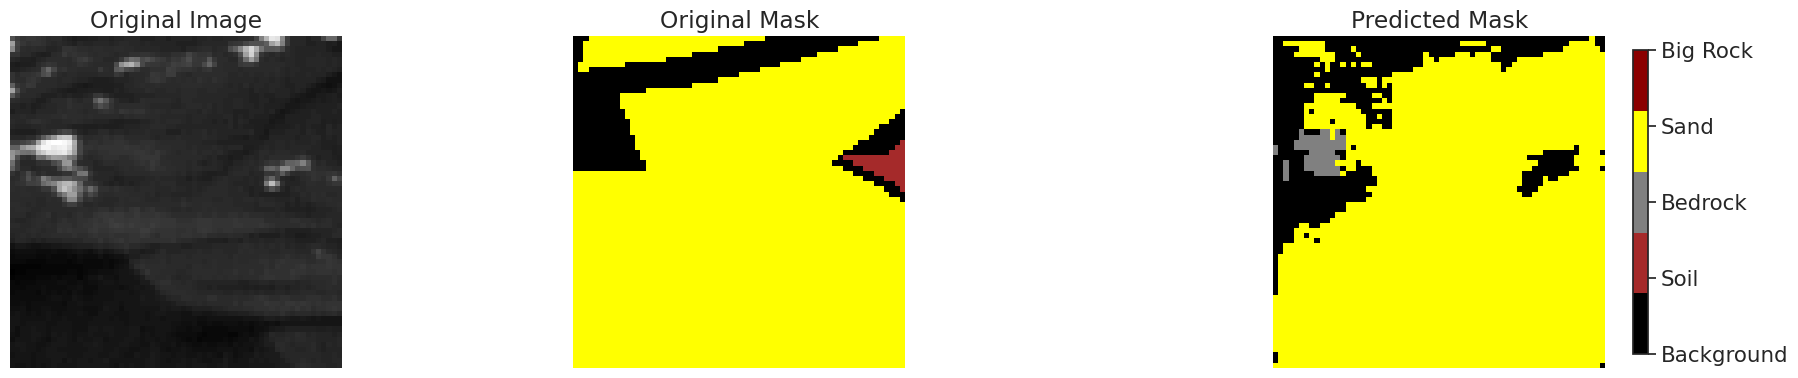

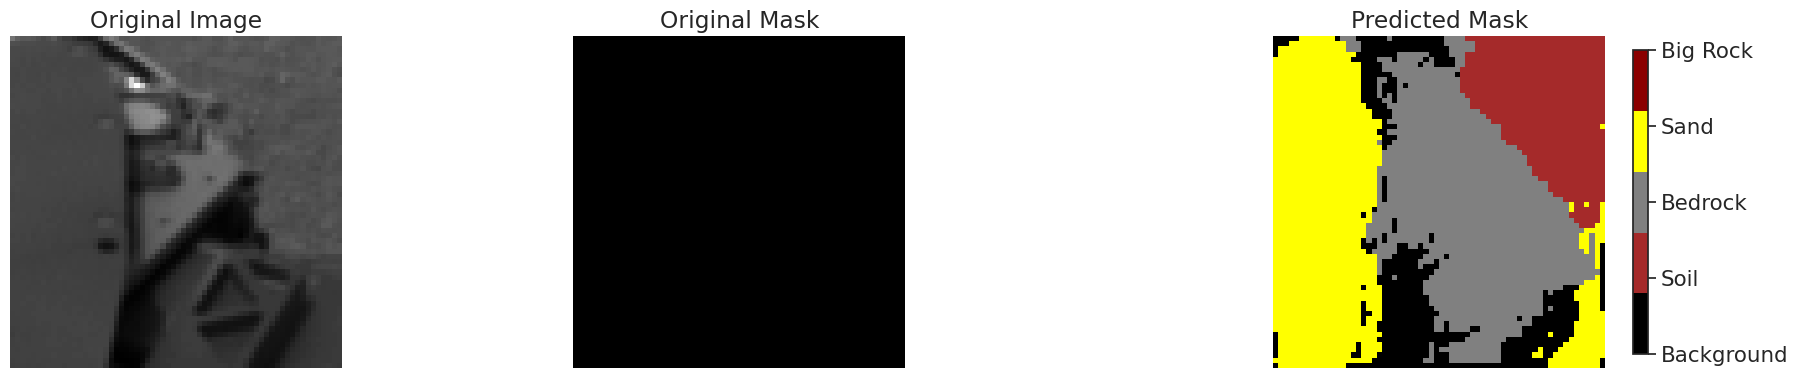

In [ ]:
# Load model
model_filename = 'TextGeom_function_46.25_20241207-200716.keras'
model = tfk.models.load_model(os.path.join('data_augmentations', model_filename), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=focal_loss(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset3, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset3, model, num_samples=3)

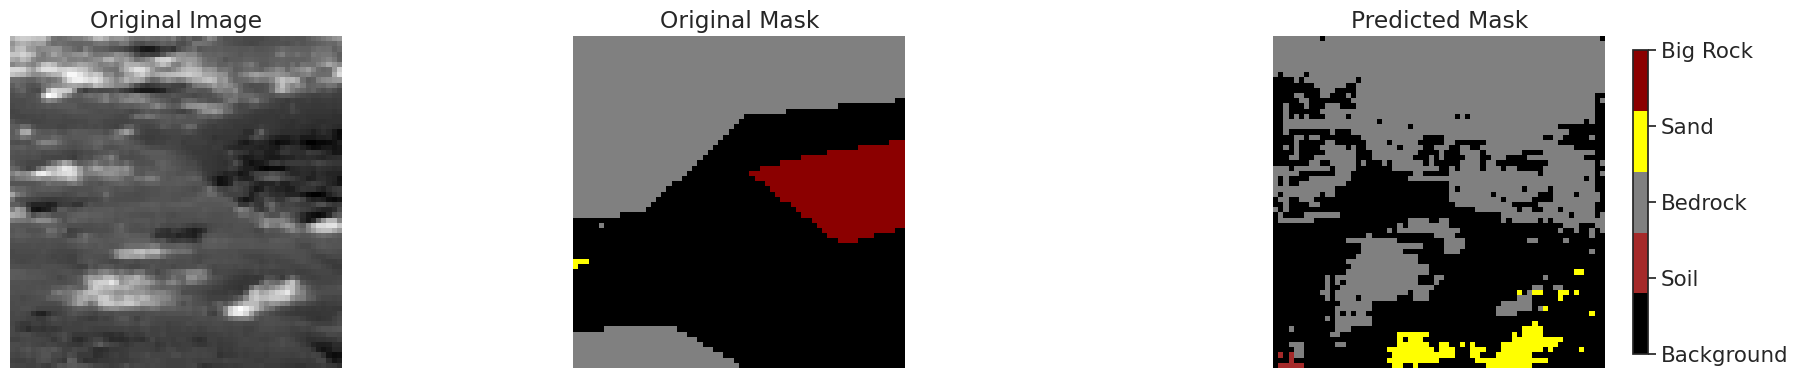

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=seed)

In [ ]:
# Turn into np
X_final_test = to_np(final_test_dataset3)

# Compute predictions
predictions = model.predict(X_final_test)
predictions = np.argmax(predictions, axis=-1)

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(predictions)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

X_train_np shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Geometrical + Noise + Texture

In [ ]:
# Augmentation, applied to train, validation and test
augment_geometrical = True
augment_noise = True
augment_texture = True

train_dataset4 = make_dataset(
      dataset=train_dataset,
      augment_geometrical=augment_geometrical,
      augment_noise=augment_noise,
      augment_texture=augment_texture,
      batch_size=BATCH_SIZE,
      seed=seed
  )
val_dataset4 = make_dataset(
    dataset=val_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)
test_dataset4 = make_dataset(
    dataset=test_dataset,
    augment_geometrical=augment_geometrical,
    augment_noise=augment_noise,
    augment_texture=augment_texture,
    batch_size=BATCH_SIZE,
    seed=seed
)

# Compute statistics on the training dataset
mean, std = compute_dataset_statistics(train_dataset4)

# Apply dynamic normalization to datasets
train_dataset4 = train_dataset4.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
val_dataset4 = val_dataset4.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
test_dataset4 = test_dataset4.map(lambda img, lbl: normalize_dynamic(img, lbl, mean, std))
final_test_dataset4 = final_test_dataset.map(lambda img: normalize_dynamic_nolbl(img, mean, std))

# Filter the test dataset to include only samples containing 'Big Rock'
filtered_test_dataset = test_dataset4.unbatch().filter(lambda image, label: contains_big_rock(image, label)).batch(BATCH_SIZE)

In [ ]:
history, model_filename = train_unet(loss_fn=loss, train_dataset=train_dataset4, val_dataset=val_dataset4, model_name="GeomNoiText")

Epoch 1/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 60s 55ms/step - accuracy: 0.5106 - loss: 0.1767 - mean_iou: 0.2649 - val_accuracy: 0.6556 - val_loss: 0.1141 - val_mean_iou: 0.3732 - learning_rate: 1.0000e-04
Epoch 2/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 59s 35ms/step - accuracy: 0.6416 - loss: 0.1125 - mean_iou: 0.3579 - val_accuracy: 0.6590 - val_loss: 0.1052 - val_mean_iou: 0.3749 - learning_rate: 1.0000e-04
Epoch 3/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 40s 35ms/step - accuracy: 0.6671 - loss: 0.1009 - mean_iou: 0.3759 - val_accuracy: 0.7050 - val_loss: 0.0899 - val_mean_iou: 0.4254 - learning_rate: 1.0000e-04
Epoch 4/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 29s 34ms/step - accuracy: 0.6787 - loss: 0.0951 - mean_iou: 0.3876 - val_accuracy: 0.7164 - val_loss: 0.0873 - val_mean_iou: 0.4181 - learning_rate: 1.0000e-04
Epoch 5/50
768/768 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.6906 - loss: 0.0901 - mean_iou: 0.3985 - val_accuracy: 0.7103 - val_loss: 0.0862 - val_mean_iou: 0.4118 - learning_rate: 1.0000e-04


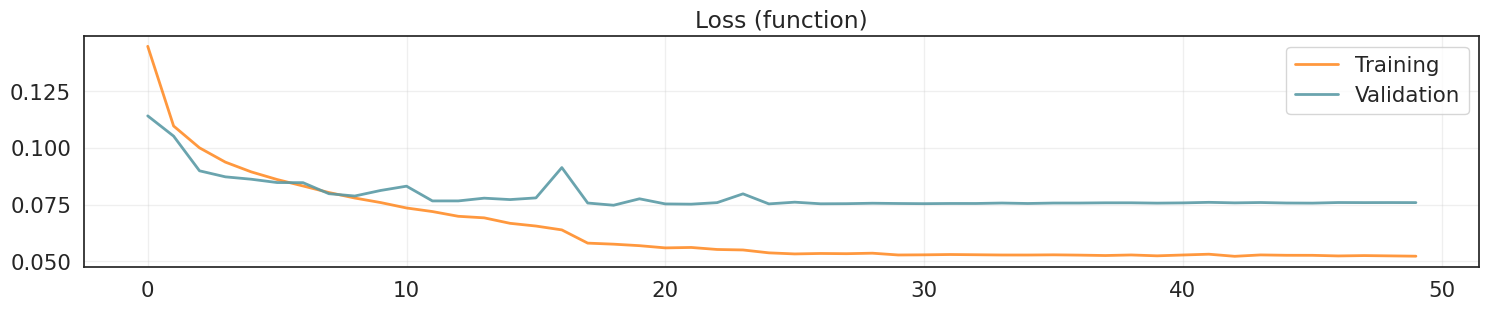

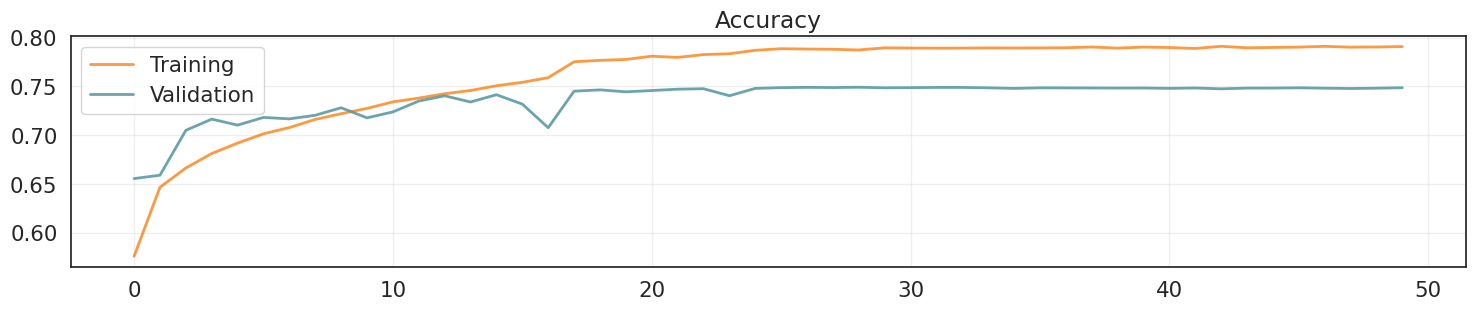

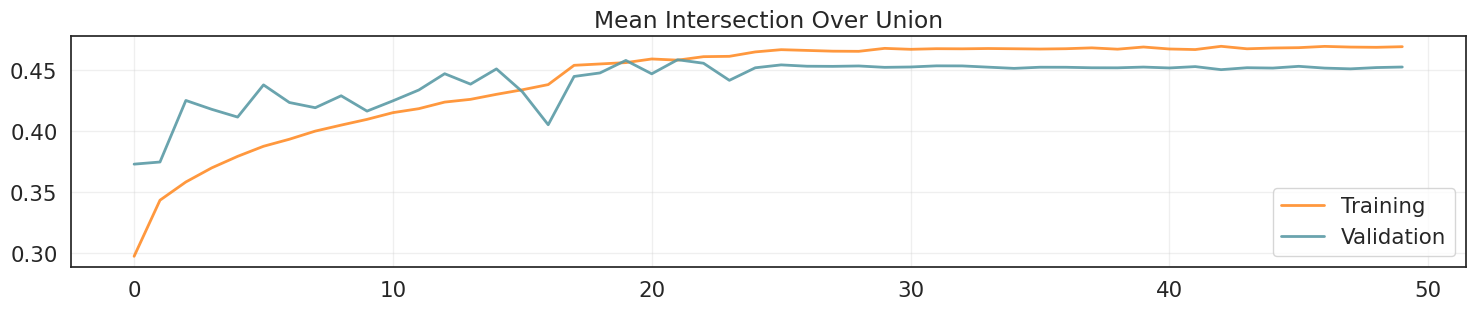

In [ ]:
plot_history(history, loss)

Test Accuracy: 0.6317
Test Mean Intersection over Union: 0.3539


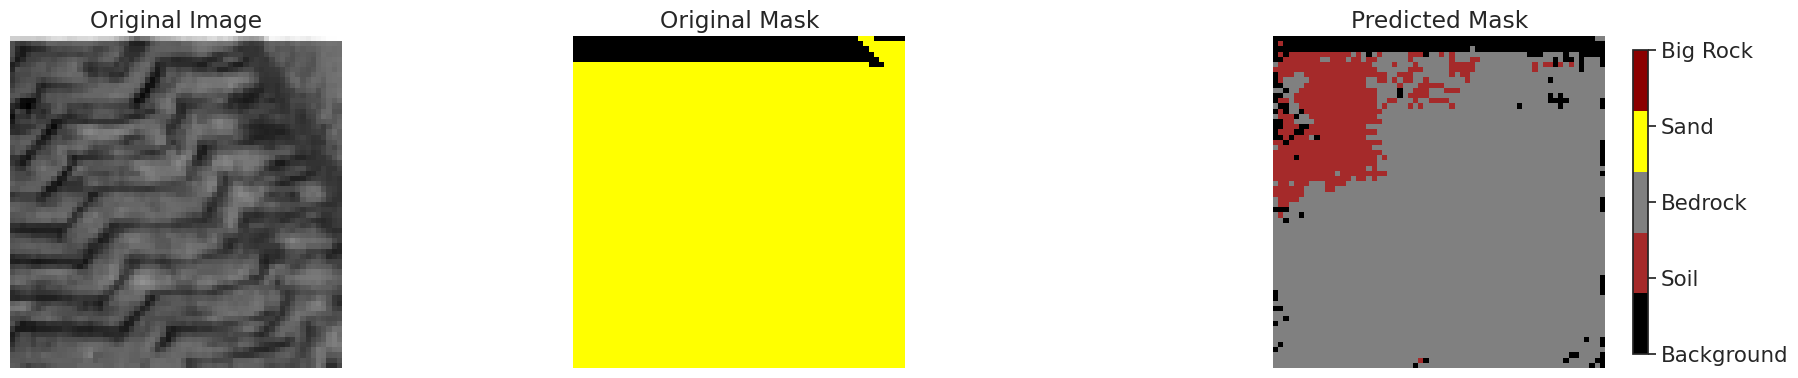

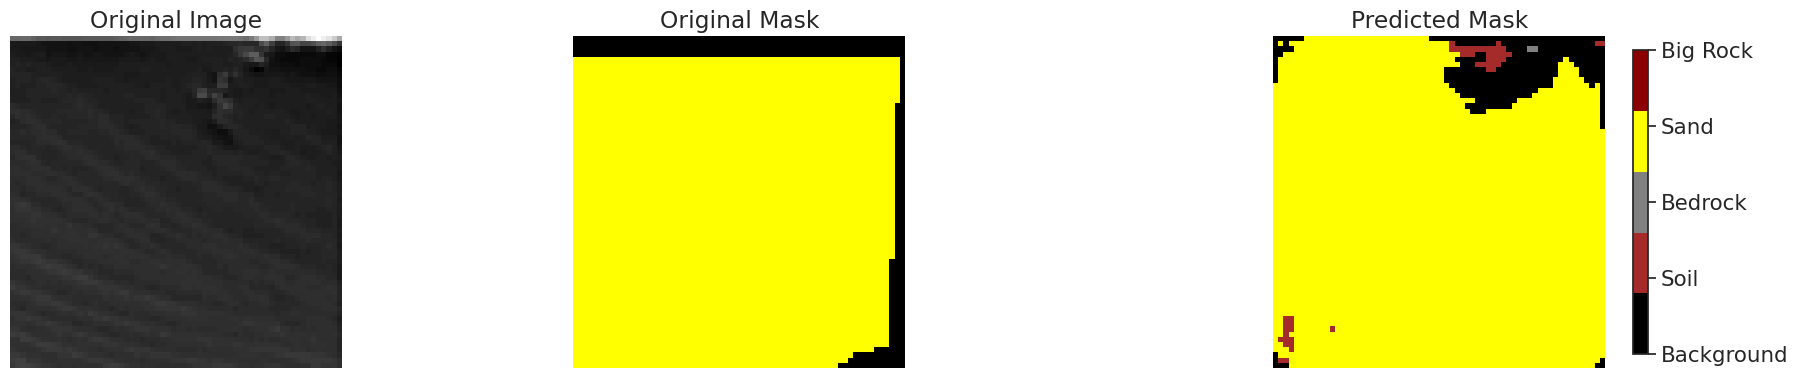

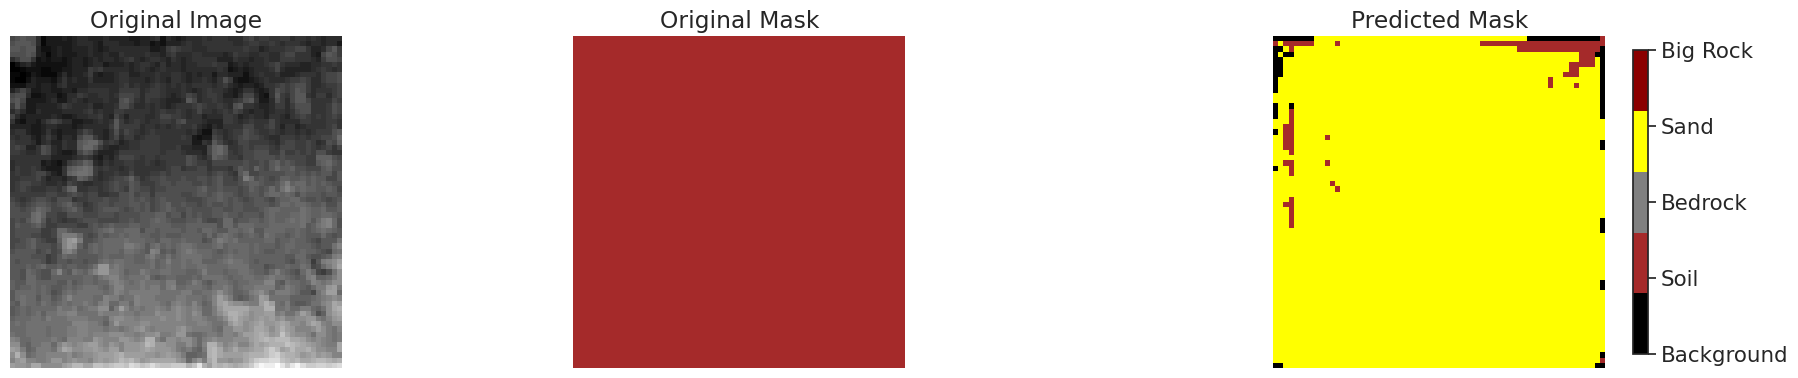

In [ ]:
# Load model
model_filename = 'GeomNoiText_function_45.88_20241207-203856.keras'
model = tfk.models.load_model(os.path.join('data_augmentations', model_filename), compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=focal_loss(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset4, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

# Plot three random samples
plot_triptychs(test_dataset4, model, num_samples=3)

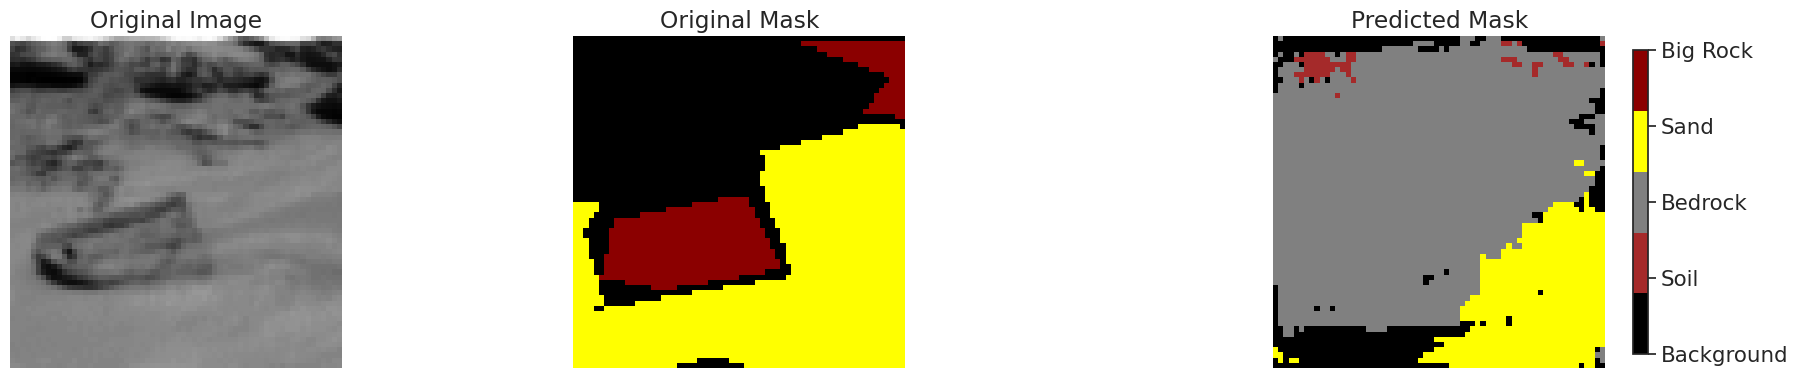

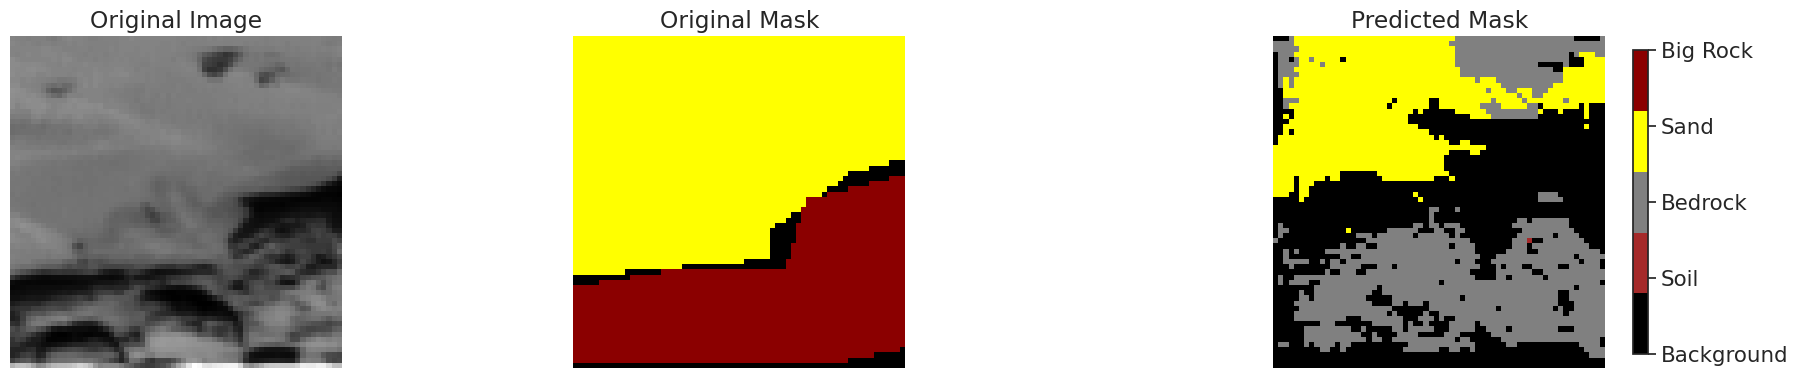

In [ ]:
# Plot triptychs using the filtered dataset
plot_triptychs(filtered_test_dataset, model, num_samples=5, seed=seed)

In [ ]:
# Turn into np
X_final_test = to_np(final_test_dataset4)

# Compute predictions
predictions = model.predict(X_final_test)
predictions = np.argmax(predictions, axis=-1)

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(predictions)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

X_train_np shape: (10022, 64, 128)
314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Comparison

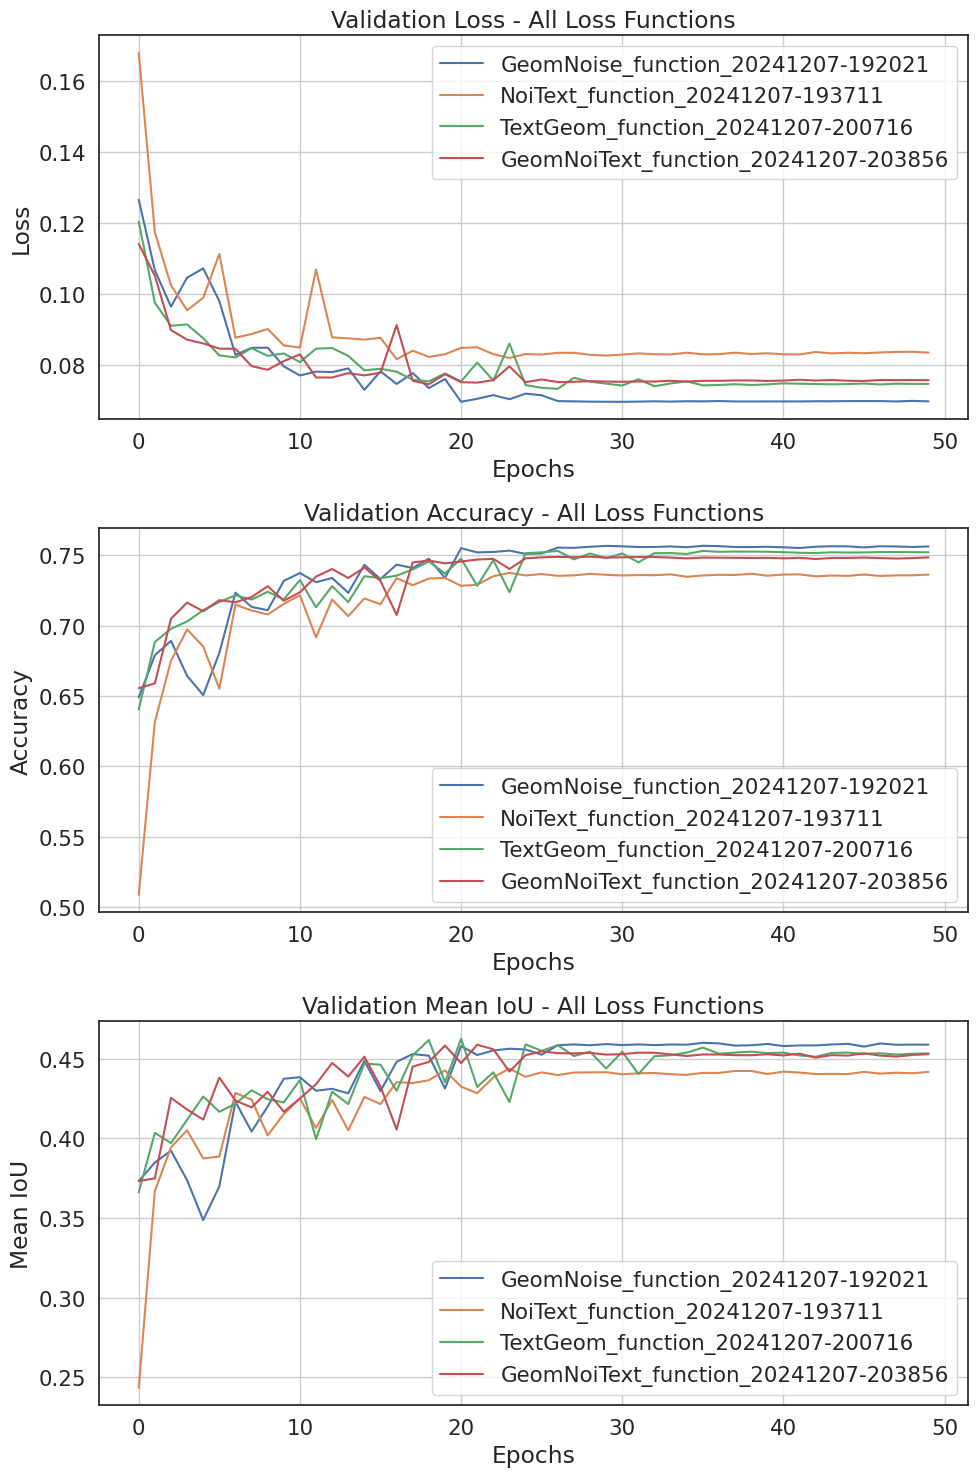

In [ ]:
import re
import json

# Path to the directory containing history JSON files
history_directory = "data_augmentations"

# Initialize dictionaries to store metrics for each loss function
loss_data = {}
accuracy_data = {}
mean_iou_data = {}
loss_fn_names = []  # Store the names of the loss functions

# Function to extract the name after 'history_' in the filename
def extract_loss_fn_name(filename):
    match = re.search(r'history_(\S+)', filename)
    if match:
        return match.group(1).replace(".json", "")
    else:
        return "Unknown"

# Load all history files from the directory
for filename in os.listdir(history_directory):
    if filename.endswith(".json"):
        # Get the full path of the JSON file
        file_path = os.path.join(history_directory, filename)

        # Load the JSON file
        with open(file_path, 'r') as f:
            history = json.load(f)

        # Extract the loss function name from the filename
        loss_fn_name = extract_loss_fn_name(filename)

        # Store loss function name
        loss_fn_names.append(loss_fn_name)

        # Extract relevant metrics
        val_losses = history.get('val_loss', [])
        val_accuracies = history.get('val_accuracy', [])
        val_mean_iou = history.get('val_mean_iou', [])

        # Store the metrics in dictionaries
        loss_data[loss_fn_name] = val_losses
        accuracy_data[loss_fn_name] = val_accuracies
        mean_iou_data[loss_fn_name] = val_mean_iou

# Assuming all histories have the same number of epochs (check if they do)
epochs = range(len(next(iter(loss_data.values()))))

# Plot settings
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Top subplot: Validation Loss
for loss_fn, losses in loss_data.items():
    axs[0].plot(epochs, losses, label=loss_fn)
axs[0].set_title('Validation Loss - All Loss Functions')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(loc='best')
axs[0].grid(True)

# Middle subplot: Validation Accuracy
for loss_fn, accuracies in accuracy_data.items():
    axs[1].plot(epochs, accuracies, label=loss_fn)
axs[1].set_title('Validation Accuracy - All Loss Functions')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(loc='best')
axs[1].grid(True)

# Bottom subplot: Validation Mean IoU
for loss_fn, mean_ious in mean_iou_data.items():
    axs[2].plot(epochs, mean_ious, label=loss_fn)
axs[2].set_title('Validation Mean IoU - All Loss Functions')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Mean IoU')
axs[2].legend(loc='best')
axs[2].grid(True)

# Show the plot
plt.tight_layout()
plt.show()